In [2]:
#!pip install pandas
#!pip install pillow
#!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 50.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 kB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 21.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 1.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 42.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.0/306.0 kB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 33.6 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 90.5 MB/s eta 0:00:00


In [20]:
import os
#os.environ["KERAS_BACKEND"] = "torch"
import numpy as np
import pandas as pd
from PIL import Image
import random
#import torch
import keras
import h5py
import matplotlib.pyplot as plt
import bz2
import zipfile
import requests
import gc
import timeit
import tensorflow as tf
print(tf.__version__)
print(keras.__version__)
import kaggle
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

2.16.1
3.0.5


In [4]:
#print(keras.backend.backend())
#print(torch.__version__)

In [5]:
# Import the labels
input_directory = "kaggle/input/histopathologic-cancer-detection/"
working_directory = "kaggle/working/"
tmp_directory = "kaggle/temp/"


In [6]:
def download_file(url, folder_path, local_filename):
    # Make a request to the URL
    response = requests.get(url)
    response.raise_for_status()  # Raise an error for bad responses

    # Create the full path to the file
    file_path = os.path.join(folder_path, local_filename)

    # Write the file content in binary mode to the specified folder
    with open(file_path, 'wb') as file:
        file.write(response.content)



In [7]:
#Download Kaggle File
url = 'https://storage.googleapis.com/isaac_blach_ml_storage/histopathologic-cancer-detection.zip'
folder_path = input_directory
local_filename = 'histopathologic-cancer-detection.zip'

download_file(url, folder_path, local_filename)

In [8]:
with zipfile.ZipFile(input_directory + "histopathologic-cancer-detection.zip", 'r') as zip_ref:
    zip_ref.extractall(input_directory)

In [16]:
directory = input_directory + "train_labels.csv"
images = pd.read_csv(directory)
images.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


# EDA
There are 22k RGB images in this data set.  They are 32x32.  If there is a 0, there are no cancerous cells in the center of the image, if 1 then there are cancerous cells in the middle of the image.

There are a moderate skew tward non-cancerous cells.  This 40/60 skew could have impacts on the training and results but in this case I choose to just run with it.

Visually, the color pallet is heavily tilted tward red/purple.  This could have brought an opportunity to convert the images to greyscale for performance if desired.  I chose not to in this instance.

# Cleaning
The images were claimed to have been cleaned, unique, and to have enough pixels around the image to use convolutional teqniques. Due to this, I choose to not perform further cleaning.

In [21]:
print("Count of Categories: ")
print(images.groupby('label').apply(len))
print("Percent of non-cancerous")
print(images.groupby('label').apply(len)[1]/(images.groupby('label').apply(len)[0]+images.groupby('label').apply(len)[1]))

Count of Categories: 
label
0    130908
1     89117
dtype: int64
Percent of non-cancerous
0.40503124644926713


Cancerous


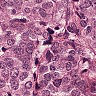

Cancer Free


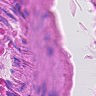

Cancer Free


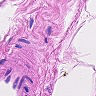

Cancer Free


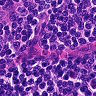

Cancerous


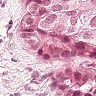

Cancer Free


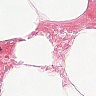

Cancer Free


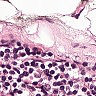

Cancer Free


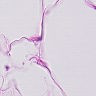

Cancer Free


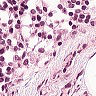

Cancerous


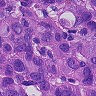

In [19]:
#print random images with lablels
samples = images.iloc[random.sample(range(0,images.shape[0]), 10)]
#print(samples)
for sample in samples.iterrows():
    #print(sample[1])
    path = input_directory + "train/" + str(sample[1]["id"]) + ".tif"
    if sample[1]["label"] == 0:
        print("Cancer Free")
    else:
        print("Cancerous")
    im = Image.open(path)
    display(im)


# Data Loading and initial transformations
I started with loading the images.  I chose to load the images back to the pandas dataframe, and then convert the images and results to a pair of matched numpy arrays.  This conversion allowed me to use store the arrays for faster loading as image processing takes a while.  



In [16]:
#GPT assisted class

def load_and_process_image(filename):
    path=input_directory + "train/" + filename + ".tif"
    im = keras.utils.load_img(path, color_mode='rgb', target_size=(32,32))
    return keras.utils.img_to_array(im)/255


In [ ]:
images['image_data'] = images['id'].apply(load_and_process_image)
X_val = np.stack(images['image_data'].values)

In [17]:
# Store the results in a file for faster loading
X = np.stack(images['image_data'].values)
y = images['label'].values
path = working_directory + 'image_data.h5'
hdf5_file = path

with h5py.File(hdf5_file, 'w') as f:
    f.create_dataset('images', data=X)
    f.create_dataset('labels', data=y)

In [18]:
#BZ2 Compress for cloud storage
with open(working_directory + "image_data.h5", 'rb') as input_file:
    with bz2.open(working_directory + "image_data.bz2", 'wb', compresslevel=9) as output_file:
        output_file.writelines(input_file)

# Saving the dataset offline
I chose to save my pandas offlne as it was faster to download and unzip my in-progress work than it would be to do the image processing from scratch every time.

# Expanding the training set
After research, I found that  good pratice in trianing image data is to rotate and shift the training set to create a better and more complete training set.  In researching this problem, just rotating all the images can create a 5% increase in accuracy if properly tuned.  In my case I got ~3% improvement.  This did have the unfortunate side effect of taking my dataset from 22k images to 88k images and taking 4x the training time.  

# Splitting the Datset
During the setup, I set the dataset up to use an automatic 80/20 split for Train/Validation.

In [23]:
# Download images non-rotated
url = 'https://storage.googleapis.com/isaac_blach_ml_storage/image_data.bz2'
folder_path = working_directory
local_filename = 'image_data.bz2'

download_file(url, folder_path, local_filename)

#unbz2 images for git storage
with bz2.open(working_directory + "image_data.bz2", 'rb') as compressed_file:
    with open(working_directory + "image_data.h5", 'wb') as decompressed_file:
        # Copy the decompressed data to a new file
        decompressed_file.write(compressed_file.read())

In [24]:
# Load dataset from file
path = working_directory + 'image_data.h5'
hdf5_file = path
with h5py.File(hdf5_file, 'r') as f:
    # Load the datasets back into memory
    X = f['images'][:]
    y = f['labels'][:]

In [25]:
# Rotate Images

def rotate_images(images, k):
    return np.rot90(images, k=k, axes = (1,2))

X_rotated = np.concatenate((X, rotate_images(X, 1), rotate_images(X, 2), rotate_images(X, 3)))
y_rotated = np.concatenate((y,y,y,y))

print("X Shape: " + str(X.shape))
print("X Rotated Shape: " + str(X_rotated.shape))
print("y Shape: " + str(y.shape))
print("y Shape: " + str(y_rotated.shape))

X Shape: (220025, 32, 32, 3)
X Rotated Shape: (880100, 32, 32, 3)
y Shape: (220025,)
y Shape: (880100,)


# Simplifying the model building process
To simplify the model building process, I created methods to call/create my filters in 1 line chunks.  This is where I defined all those 1 line items you see in my operational blocks.

In [26]:
# Developed with help from https://keras.io/api/models/model/

def convolution_block(inputs, filters, activation = "relu"):
    filters = filters
    kernel_size=(3,3)
    conv1 = keras.layers.Conv2D(
        filters,
        kernel_size,
        strides=(1, 1),
        padding="valid",
        data_format=None,
        dilation_rate=(1, 1),
        groups=1,
        activation=activation,
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
    ) (inputs)
    return conv1

def pool_block(inputs):
    pool = keras.layers.MaxPooling2D(
        pool_size=(2, 2), strides=None, padding="valid", data_format=None, name=None
    )(inputs)
    return pool

def dropout_block(inputs, dropout_value):
    dropout = keras.layers.Dropout(dropout_value)(inputs)
    return dropout

def activation_block(inputs, layer_density): 
    dense = keras.layers.Dense(layer_density, activation='relu') (inputs)
    return dense

def prep_one_block():
    dropout_value = .25
    inputs = keras.Input(shape=(32,32,3))
    convolution = inputs
    for i in range(0,1):
        convolution = convolution_block(convolution, 32)
        convolution = convolution_block(convolution, 32)
        convolution = pool_block(convolution)
        
    flatten= keras.layers.Flatten()(convolution)

    activation = flatten
    for i in range(0,1):
        activation = activation_block(activation,1024)
        activation = dropout_block(activation, dropout_value)
    outputs = keras.layers.Dense(1, activation="sigmoid")(activation)
    full_model = keras.Model(inputs, outputs)
    return full_model



In [27]:
#The method to compile and fit the model
def run_model(full_model, learning_rate, X, y, epochs = 10, callbacks = None):
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    full_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[keras.metrics.BinaryAccuracy()])
    history = full_model.fit(
        x=X,
        y=y,
        batch_size=128,
        epochs=epochs,
        verbose=0,
        callbacks=callbacks,
        validation_split=0.2,
        validation_data=None,
        shuffle=True,
        class_weight=None,
        sample_weight=None,
        initial_epoch=0,
        steps_per_epoch=None,
        validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    )
    return full_model, history
    


# Tensor Flow Memory Leak
In tensor flow, there is a memory leak that caused me no end to problems.  Due to this, initially on 8gb cards, I would only be able to do 1-2 model trains before getting a GPU OOM.  I resolved this by renting a 4090 from vast.ai.  This issue took me almost a full day of fustration to find a place to get the hardware I needed to do this.

the reset_keras is a method to try to force the gpu to garbage collect and fix the memory leak

# Graphing
My first questionable desicion was here.  I chose to use a single plotting function, to plot train and validation accuracy for a single run at once, and not to store the results anywhere.  This was a major mistake as I had to do multiple re-runs just to fix graphing issues costing time.  
Lesson learned, store the data in a Data Frame, write to disk and then graph.

In [31]:
# Stolen Shamelessly from https://github.com/keras-team/keras/issues/12625 
# Clears up GPU out of memory
#from tensorflow.keras import backend as K

# Reset Keras Session
def reset_keras():
    #K.clear_session()
    gc.collect()
    #tf.keras.backend.clear_session()
          

# Chatgpt wrote this imaging plot
def plot_error(train_accuracy, val_accuracy, text):
    epochs = range(1, len(train_accuracy) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o', linestyle='-', color='blue')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o', linestyle='-', color='red')

    # Loop through each epoch and add text annotation for training and validation accuracy
    for i, (train_acc, val_acc) in enumerate(zip(train_accuracy, val_accuracy)):
        plt.text(i + 1, train_acc, f'{train_acc:.2f}', ha='center', va='bottom')
        plt.text(i + 1, val_acc, f'{val_acc:.2f}', ha='center', va='top')
    
    title_string = text
    plt.title(title_string)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')  # Changed 'Loss' to 'Accuracy' as we are plotting accuracy values
    plt.legend()
    plt.grid(True)
    plt.show()

# First Runs
This is my first 2 runs, to test unrotated images and rotated images.  The rotated images did 3% better with 4x the time.  The first run with the rotated images was ~89%, a good start.
# My first Big Mistake
My first big mistake was here.  I started by setting the hidden layer to Sigmoid and the output layer to Relu, casuing me to have a 70% accuracy.  I fixed this and reran, but that took a while to run down.

2024-04-20 19:33:16.545488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22283 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:a1:00.0, compute capability: 8.9
I0000 00:00:1713641602.032119   83508 service.cc:145] XLA service 0x7fcf40004ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713641602.032197   83508 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-04-20 19:33:22.150171: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-20 19:33:22.337770: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1713641604.265491   83508 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the life

43.11685061798198


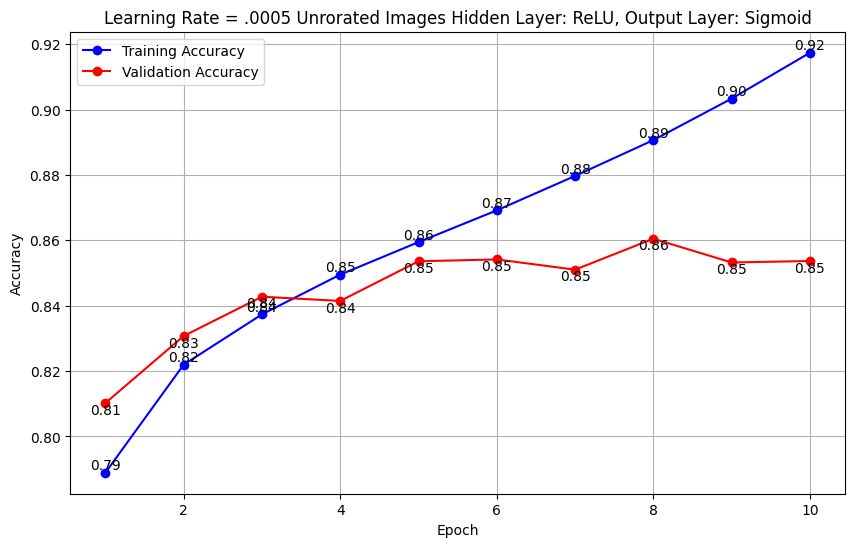

In [10]:
model = prep_one_block()
start_time = timeit.default_timer()
_, history = run_model(model, .0005, X, y)
print(timeit.default_timer() - start_time)
text = "Learning Rate = .0005 Unrorated Images Hidden Layer: ReLU, Output Layer: Sigmoid"
plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
del(model)
reset_keras()

185.62978986400412


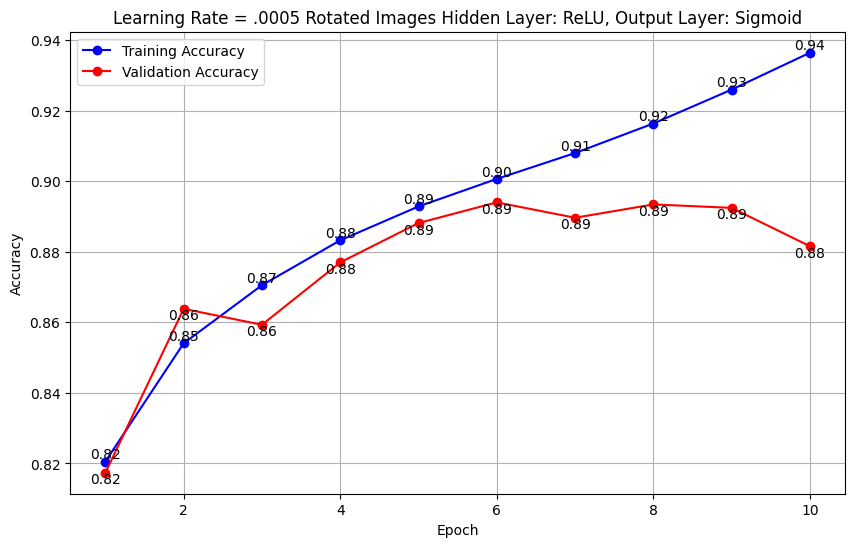

In [15]:
model = prep_one_block()
start_time = timeit.default_timer()
_, history = run_model(model, .0005, X_rotated, y_rotated)
print(timeit.default_timer() - start_time)
text = "Learning Rate = .0005 Rotated Images Hidden Layer: ReLU, Output Layer: Sigmoid"
plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
del(model)
reset_keras()

## Initial Impressions
.85 Validation with the unrotated images is ok.  With rotated Images, I'm getting .89. but after the 5-8th epoch, there is major overfitting.

## Testing different hidden layers and output layers
Testing with different output layers showed that in this case, SoftMax was a clear winner.  I was unalbe to test Prelu due to limitiations of keras and my time.  

## Cutting the model off after validation accuracy starts to fall
I set up a callback to stop the model from training 2 epochs after the validation accuracy was down for 2 consecutive epochs.

2024-04-30 01:21:19.219502: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8651735040 exceeds 10% of free system memory.


77.40982831502333


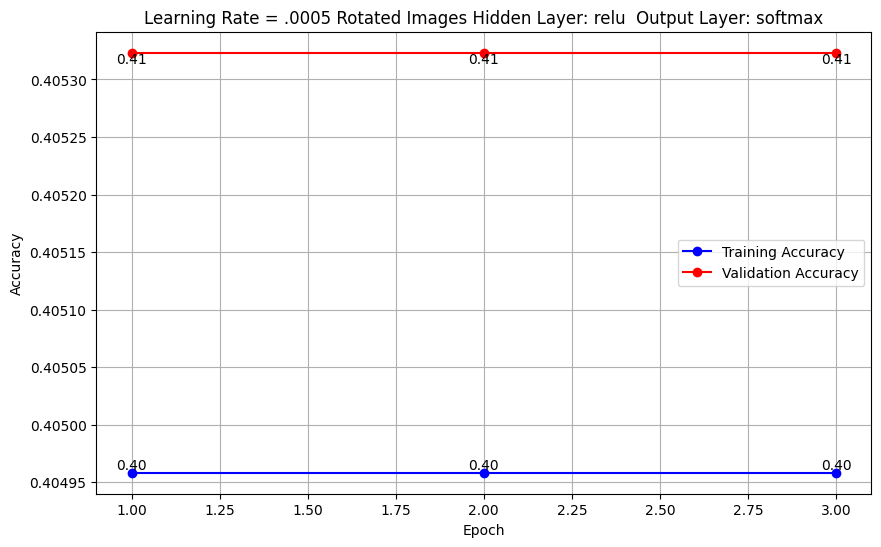

73.4680761480704


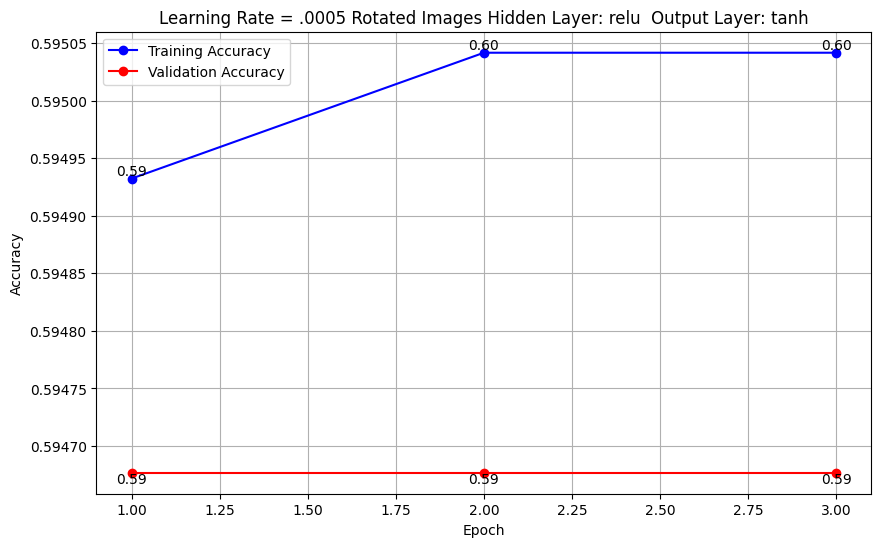

In [32]:
# Test different hidden layers

output_layers = ["softmax", "tanh"]
hidden_layer = "relu"
for output_layer in output_layers:
    dropout_value = .25
    inputs = keras.Input(shape=(32,32,3))
    convolution = inputs
    for i in range(0,1):
        convolution = convolution_block(convolution, 32, hidden_layer)
        convolution = convolution_block(convolution, 32, hidden_layer)
        convolution = pool_block(convolution)

    flatten= keras.layers.Flatten()(convolution)

    activation = flatten
    for i in range(0,1):
        activation = activation_block(activation,1024)
        activation = dropout_block(activation, dropout_value)
    outputs = keras.layers.Dense(1, activation=output_layer)(activation)
    full_model = keras.Model(inputs, outputs)
    start_time = timeit.default_timer()
    callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy",patience=2)
    _, history = run_model(full_model, .0005, X_rotated, y_rotated, callbacks = callback)
    print(timeit.default_timer() - start_time)
    text = "Learning Rate = .0005 Rotated Images Hidden Layer: " + hidden_layer + "  Output Layer: " + output_layer
    plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
    del(full_model)
    reset_keras()

# Best Hidden and Output Layer
PReLU did not end up working with Keras for some reason.  It does not apppear to be a standard tensor flow output layer.  I will continue with RELU.  
Sigmoid was the only output layer that produced viable results.  
# Number of convolutional layers
There is a upper bound on the number of convolutional layers.  This is due to the very small size of the images.  I will test with 4 convolutional layers with a pooling layer after each 2 convolutional layers.  This is aso the max number of layers possible for this dataset.  I did 3x3 kernel, and a 2x2 pooling layer.  This change did start to push up the accuracy a bit.

This pushed me up to ~90.5% accuracy at this point.
## Convolution numbering issue
In my graphs, I say I had 2 convolution layers.  This is 2 sets of Conv-Conv-Pools.  Due to my choice of graphing and not storings results, I couldn't go back and fix this easily.

167.61287088366225


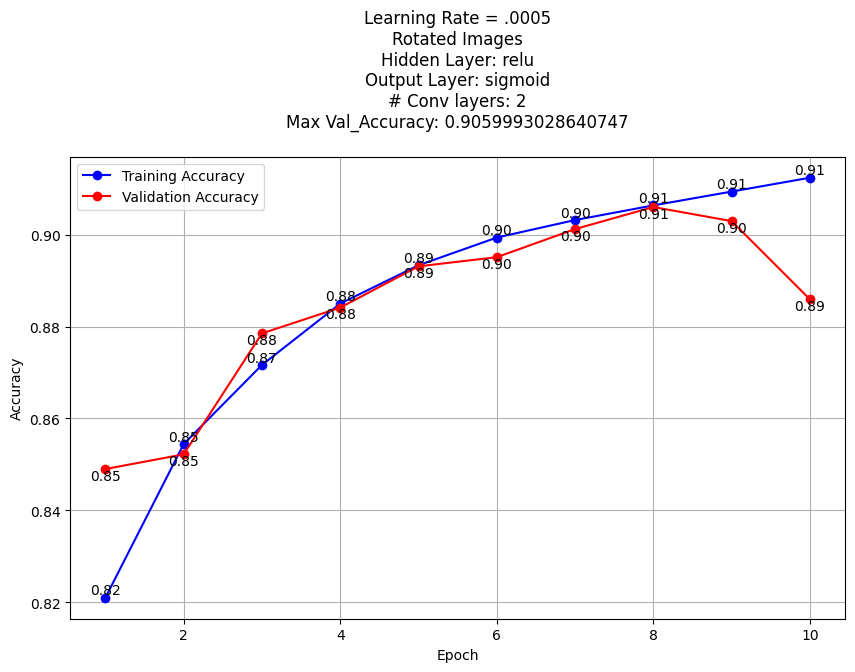

In [24]:
# Test number of convolutional layers

output_layer ="sigmoid"
hidden_layer = "relu"
hidden_layer_count = [2]
for h_layer_count in hidden_layer_count:
    dropout_value = .25
    inputs = keras.Input(shape=(32,32,3))
    convolution = inputs
    for i in range(0,h_layer_count):
        convolution = convolution_block(convolution, 32, hidden_layer)
        convolution = convolution_block(convolution, 32, hidden_layer)
        convolution = pool_block(convolution)

    flatten= keras.layers.Flatten()(convolution)

    activation = flatten
    for i in range(0,1):
        activation = activation_block(activation,1024)
        activation = dropout_block(activation, dropout_value)
    outputs = keras.layers.Dense(1, activation=output_layer)(activation)
    full_model = keras.Model(inputs, outputs)
    start_time = timeit.default_timer()
    callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy",patience=2)
    _, history = run_model(full_model, .0005, X_rotated, y_rotated,epochs = 15, callbacks = callback)
    print(timeit.default_timer() - start_time)
    text = (
        f"Learning Rate = .0005\n"
        f"Rotated Images\n"
        f"Hidden Layer: {hidden_layer}\n"
        f"Output Layer: {output_layer}\n"
        f"# Conv layers: {h_layer_count}\n"
        f'Max Val_Accuracy: {max(history.history["val_binary_accuracy"])}\n'
    )    
    plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
    del(full_model)
    reset_keras()
    

# Number of filters per layer
I tried to find how many convolutioal filters would be optimal.  I tried a range of powers of 2.  128 seemed to be optimal here.

# Stacked Convolution filters
After research, I found that it is normal to stack convolution filters in growing increments so 32-64-128-256 filters.  I chose to test several of these combinations.  The 64,128,256,512 did marginally better than straight 128, but due to mistakes I did not use that going forward, but continues with straight 128.

153.50052838679403


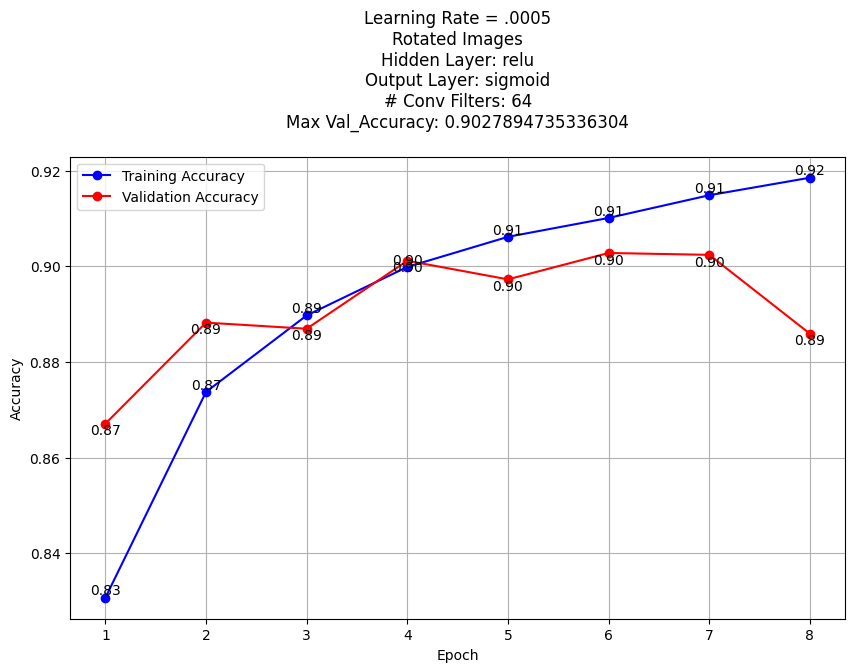

351.1165005960502


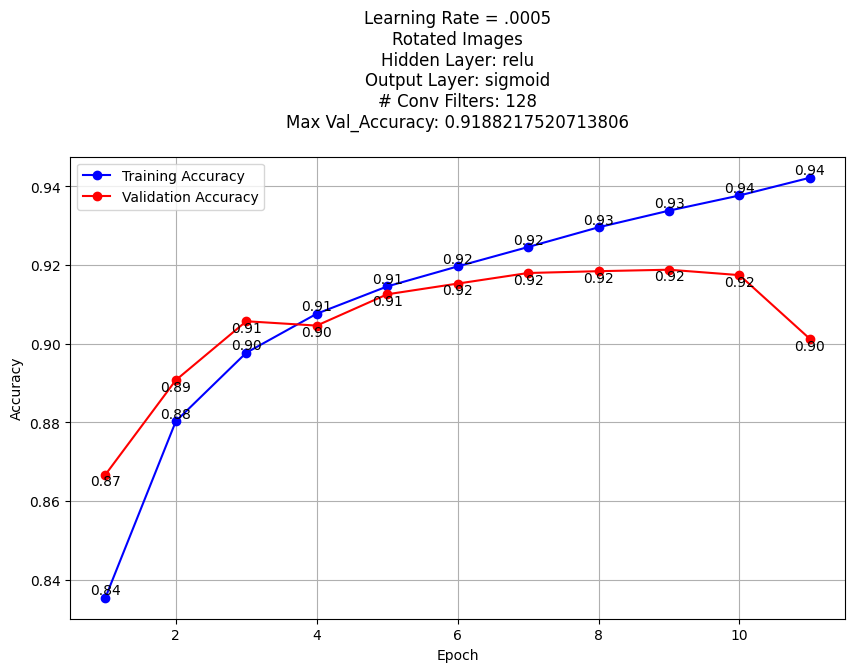

558.5296057402156


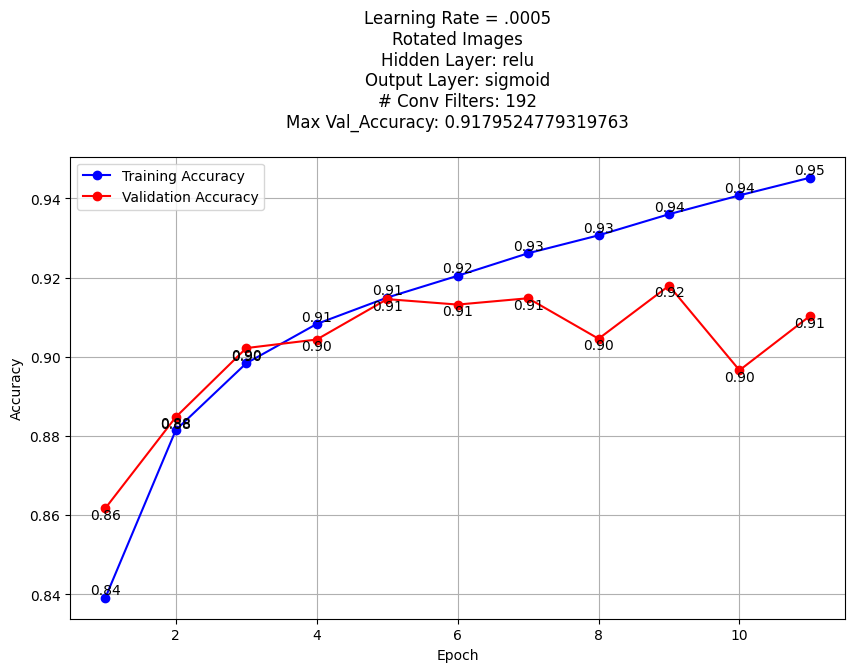

In [ ]:
# Test different hidden layers

output_layer ="sigmoid"
hidden_layer = "relu"
h_layer_count = 2
convolution_filters = [64,128,192,256]
for convolution_filter in convolution_filters:
    dropout_value = .25
    inputs = keras.Input(shape=(32,32,3))
    convolution = inputs
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = pool_block(convolution)
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = pool_block(convolution)        

    flatten= keras.layers.Flatten()(convolution)

    activation = flatten
    for i in range(0,1):
        activation = activation_block(activation,1024)
        activation = dropout_block(activation, dropout_value)
        
    outputs = keras.layers.Dense(1, activation=output_layer)(activation)
    full_model = keras.Model(inputs, outputs)
    start_time = timeit.default_timer()
    callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy",patience=2)
    _, history = run_model(full_model, .0005, X_rotated, y_rotated, epochs = 15, callbacks = callback)
    print(timeit.default_timer() - start_time)
    text = (
        f"Learning Rate = .0005\n"
        f"Rotated Images\n"
        f"Hidden Layer: {hidden_layer}\n"
        f"Output Layer: {output_layer}\n"
        f"# Conv Filters: {convolution_filter}\n"
        f'Max Val_Accuracy: {max(history.history["val_binary_accuracy"])}\n'
    )    
    plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
    del(full_model)
    reset_keras()

# Stacked Filter Testing


192.68942635692656


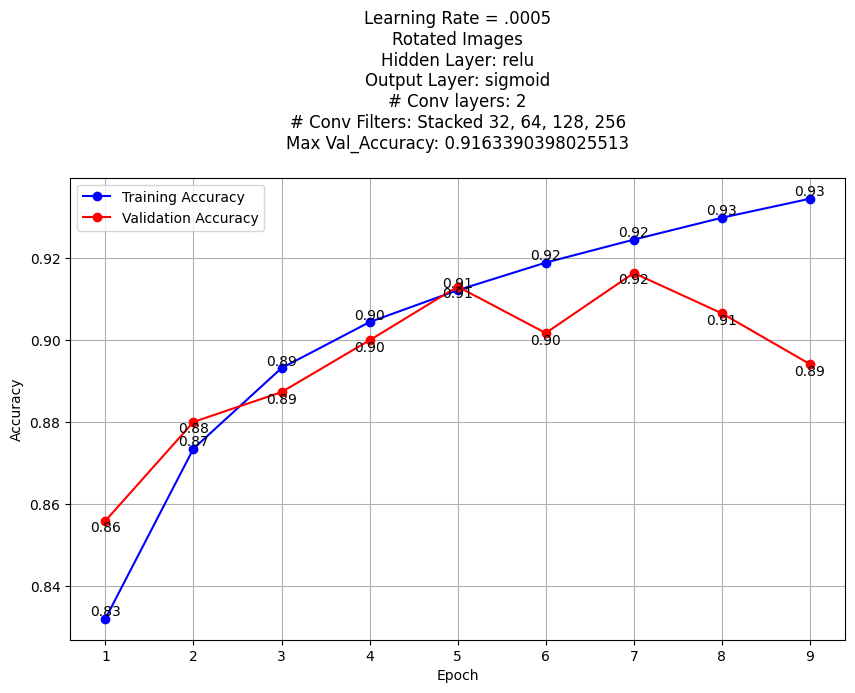

In [12]:
output_layer ="sigmoid"
hidden_layer = "relu"
h_layer_count = 2

dropout_value = .25
inputs = keras.Input(shape=(32,32,3))
convolution = inputs
convolution = convolution_block(convolution, 32, hidden_layer)
convolution = convolution_block(convolution, 64, hidden_layer)
convolution = pool_block(convolution)
convolution = convolution_block(convolution, 128, hidden_layer)
convolution = convolution_block(convolution, 256, hidden_layer)
convolution = pool_block(convolution)        

flatten= keras.layers.Flatten()(convolution)

activation = flatten
for i in range(0,1):
    activation = activation_block(activation,1024)
    activation = dropout_block(activation, dropout_value)
    
outputs = keras.layers.Dense(1, activation=output_layer)(activation)
full_model = keras.Model(inputs, outputs)
start_time = timeit.default_timer()
callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy",patience=2)
_, history = run_model(full_model, .0005, X_rotated, y_rotated, epochs = 15, callbacks = callback)
print(timeit.default_timer() - start_time)
text = (
    f"Learning Rate = .0005\n"
    f"Rotated Images\n"
    f"Hidden Layer: {hidden_layer}\n"
    f"Output Layer: {output_layer}\n"
    f"# Conv layers: {h_layer_count}\n"
    f"# Conv Filters: Stacked 32, 64, 128, 256\n"
    f'Max Val_Accuracy: {max(history.history["val_binary_accuracy"])}\n'
)    
plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
del(full_model)
reset_keras()

307.6044459301047


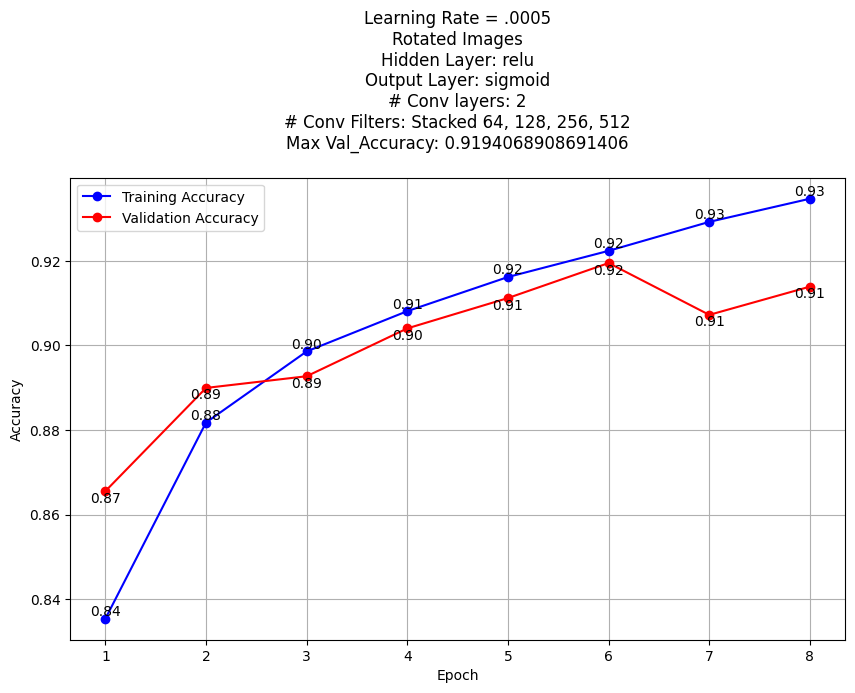

In [13]:
output_layer ="sigmoid"
hidden_layer = "relu"
h_layer_count = 2

dropout_value = .25
inputs = keras.Input(shape=(32,32,3))
convolution = inputs
convolution = convolution_block(convolution, 64, hidden_layer)
convolution = convolution_block(convolution, 128, hidden_layer)
convolution = pool_block(convolution)
convolution = convolution_block(convolution, 256, hidden_layer)
convolution = convolution_block(convolution, 512, hidden_layer)
convolution = pool_block(convolution)        

flatten= keras.layers.Flatten()(convolution)

activation = flatten
for i in range(0,1):
    activation = activation_block(activation,1024)
    activation = dropout_block(activation, dropout_value)
    
outputs = keras.layers.Dense(1, activation=output_layer)(activation)
full_model = keras.Model(inputs, outputs)
start_time = timeit.default_timer()
callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy",patience=2)
_, history = run_model(full_model, .0005, X_rotated, y_rotated, epochs = 15, callbacks = callback)
print(timeit.default_timer() - start_time)
text = (
    f"Learning Rate = .0005\n"
    f"Rotated Images\n"
    f"Hidden Layer: {hidden_layer}\n"
    f"Output Layer: {output_layer}\n"
    f"# Conv layers: {h_layer_count}\n"
    f"# Conv Filters: Stacked 64, 128, 256, 512\n"
    f'Max Val_Accuracy: {max(history.history["val_binary_accuracy"])}\n'
)    
plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
del(full_model)
reset_keras()

925.7166395201348


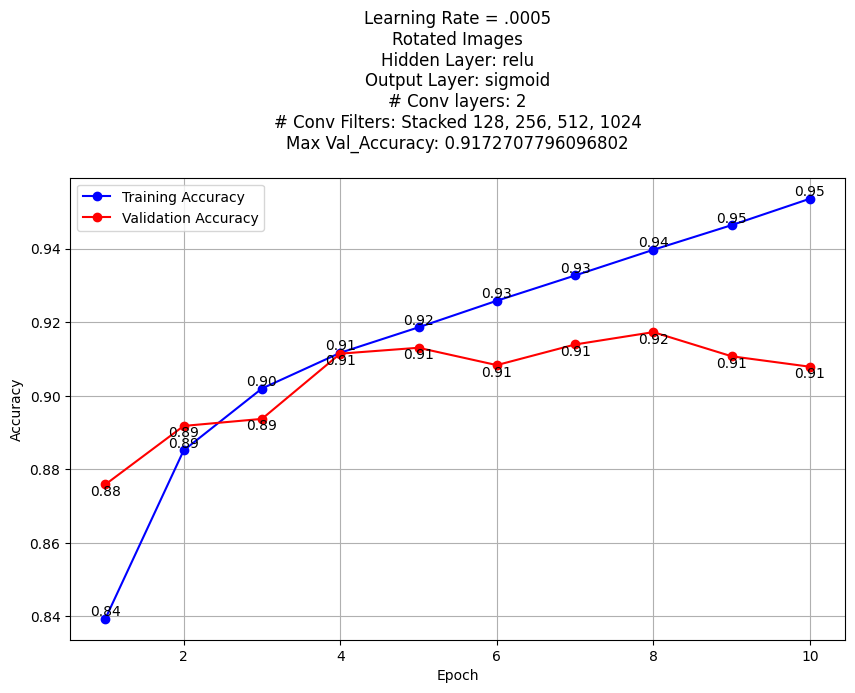

In [14]:
output_layer ="sigmoid"
hidden_layer = "relu"
h_layer_count = 2

dropout_value = .25
inputs = keras.Input(shape=(32,32,3))
convolution = inputs
convolution = convolution_block(convolution, 128, hidden_layer)
convolution = convolution_block(convolution, 256, hidden_layer)
convolution = pool_block(convolution)
convolution = convolution_block(convolution, 512, hidden_layer)
convolution = convolution_block(convolution, 1024, hidden_layer)
convolution = pool_block(convolution)        

flatten= keras.layers.Flatten()(convolution)

activation = flatten
for i in range(0,1):
    activation = activation_block(activation,1024)
    activation = dropout_block(activation, dropout_value)
    
outputs = keras.layers.Dense(1, activation=output_layer)(activation)
full_model = keras.Model(inputs, outputs)
start_time = timeit.default_timer()
callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy",patience=2)
_, history = run_model(full_model, .0005, X_rotated, y_rotated, epochs = 15, callbacks = callback)
print(timeit.default_timer() - start_time)
text = (
    f"Learning Rate = .0005\n"
    f"Rotated Images\n"
    f"Hidden Layer: {hidden_layer}\n"
    f"Output Layer: {output_layer}\n"
    f"# Conv layers: {h_layer_count}\n"
    f"# Conv Filters: Stacked 128, 256, 512, 1024\n"
    f'Max Val_Accuracy: {max(history.history["val_binary_accuracy"])}\n'
)    
plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
del(full_model)
reset_keras()

# Tuning dense layers
There are 3 hyperparamaters to tune in dense layers.  Here I did a large amount of experimentation with the number and size of dense layers.  As it turns out, for my model the optimal number of dense layers is 1, layer of a size of 256.  I also found that the optimal dropout rate for that dense layer was .75.  With this dropout, I have to wonder if a smaller dense layer and a lower dropout would have worked as well.

## Lots of graphs
I had a lot of experimenataion here.  Expect lots and lots of graphs from testing.

I0000 00:00:1714172443.302359    6066 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_78', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1714172444.047947    6061 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_78', 652 bytes spill stores, 824 bytes spill loads

I0000 00:00:1714172448.031191    6138 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_78', 260 bytes spill stores, 260 bytes spill loads



Execution Time: 340.3465871559456


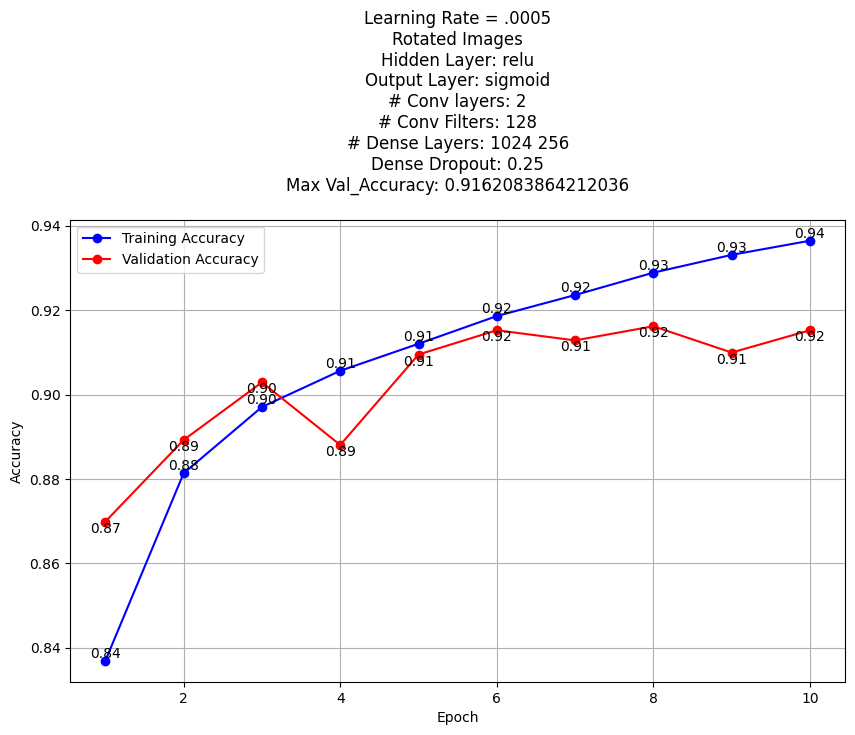

In [13]:
output_layer ="sigmoid"
hidden_layer = "relu"
h_layer_count = 2
dense_layers  = 1
dropout_value = .25
convolution_filter = 128



inputs = keras.Input(shape=(32,32,3))
convolution = inputs
convolution = convolution_block(convolution, convolution_filter, hidden_layer)
convolution = convolution_block(convolution, convolution_filter, hidden_layer)
convolution = pool_block(convolution)
convolution = convolution_block(convolution, convolution_filter, hidden_layer)
convolution = convolution_block(convolution, convolution_filter, hidden_layer)
convolution = pool_block(convolution)        

flatten= keras.layers.Flatten()(convolution)

activation = flatten

activation = activation_block(activation,1024)
activation = dropout_block(activation, dropout_value)
activation = activation_block(activation,256)
activation = dropout_block(activation, dropout_value)
    
outputs = keras.layers.Dense(1, activation=output_layer)(activation)
full_model = keras.Model(inputs, outputs)

text = (
    f"Learning Rate = .0005\n"
    f"Rotated Images\n"
    f"Hidden Layer: {hidden_layer}\n"
    f"Output Layer: {output_layer}\n"
    f"# Conv layers: {h_layer_count}\n"
    f"# Conv Filters: {convolution_filter}\n"
    f"# Dense Layers: 1024 256\n"
    f'Dense Dropout: {dropout_value}\n'
)

start_time = timeit.default_timer()
callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy",patience=2)
_, history = run_model(full_model, .0005, X_rotated, y_rotated, epochs = 15, callbacks = callback)
print("Execution Time: " + str(timeit.default_timer() - start_time))
text = text + f'Max Val_Accuracy: {max(history.history["val_binary_accuracy"])}\n'
plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
#plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
del(full_model)
reset_keras()

I0000 00:00:1714172787.383378    7353 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_80', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1714172788.082445    7364 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_80', 652 bytes spill stores, 824 bytes spill loads

I0000 00:00:1714172792.857822    7430 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_80', 260 bytes spill stores, 260 bytes spill loads



Execution Time: 318.58233919693157


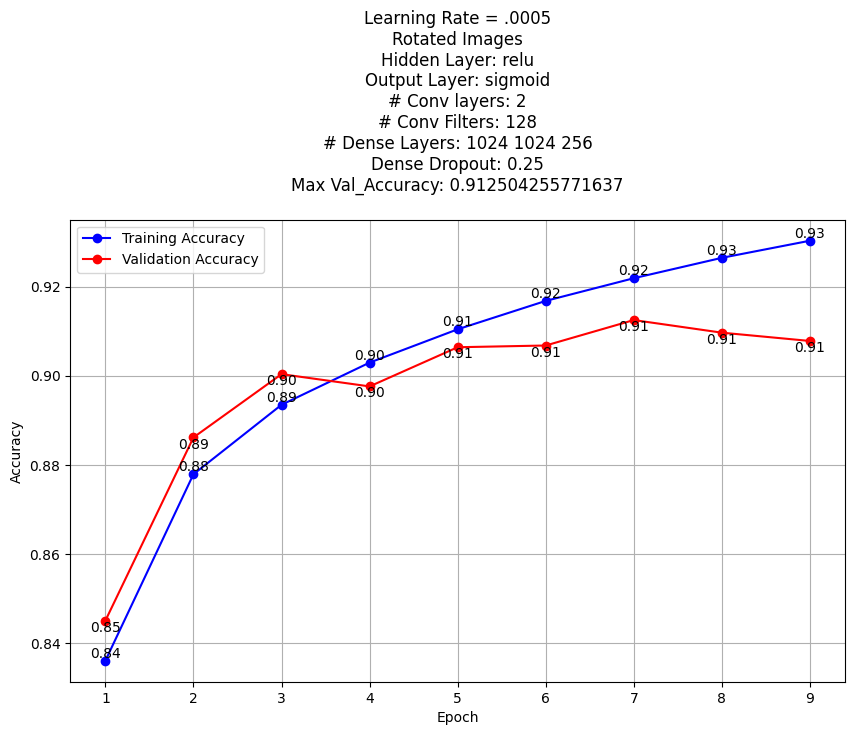

In [14]:
output_layer ="sigmoid"
hidden_layer = "relu"
h_layer_count = 2
dense_layers  = 1
dropout_value = .25
convolution_filter = 128


inputs = keras.Input(shape=(32,32,3))
convolution = inputs
convolution = convolution_block(convolution, convolution_filter, hidden_layer)
convolution = convolution_block(convolution, convolution_filter, hidden_layer)
convolution = pool_block(convolution)
convolution = convolution_block(convolution, convolution_filter, hidden_layer)
convolution = convolution_block(convolution, convolution_filter, hidden_layer)
convolution = pool_block(convolution) 

flatten= keras.layers.Flatten()(convolution)

activation = flatten

activation = activation_block(activation,1024)
activation = dropout_block(activation, dropout_value)
activation = activation_block(activation,1024)
activation = dropout_block(activation, dropout_value)
activation = activation_block(activation,256)
activation = dropout_block(activation, dropout_value)
    
outputs = keras.layers.Dense(1, activation=output_layer)(activation)
full_model = keras.Model(inputs, outputs)

text = (
    f"Learning Rate = .0005\n"
    f"Rotated Images\n"
    f"Hidden Layer: {hidden_layer}\n"
    f"Output Layer: {output_layer}\n"
    f"# Conv layers: {h_layer_count}\n"
    f"# Conv Filters: {convolution_filter}\n"
    f"# Dense Layers: 1024 1024 256\n"
    f'Dense Dropout: {dropout_value}\n'
)

start_time = timeit.default_timer()
callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy",patience=2)
_, history = run_model(full_model, .0005, X_rotated, y_rotated, epochs = 15, callbacks = callback)
print("Execution Time: " + str(timeit.default_timer() - start_time))
text = text + f'Max Val_Accuracy: {max(history.history["val_binary_accuracy"])}\n'
plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
#plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
del(full_model)
reset_keras()


## Unexpected Results for the dense layers

Execution Time: 297.50456556584686


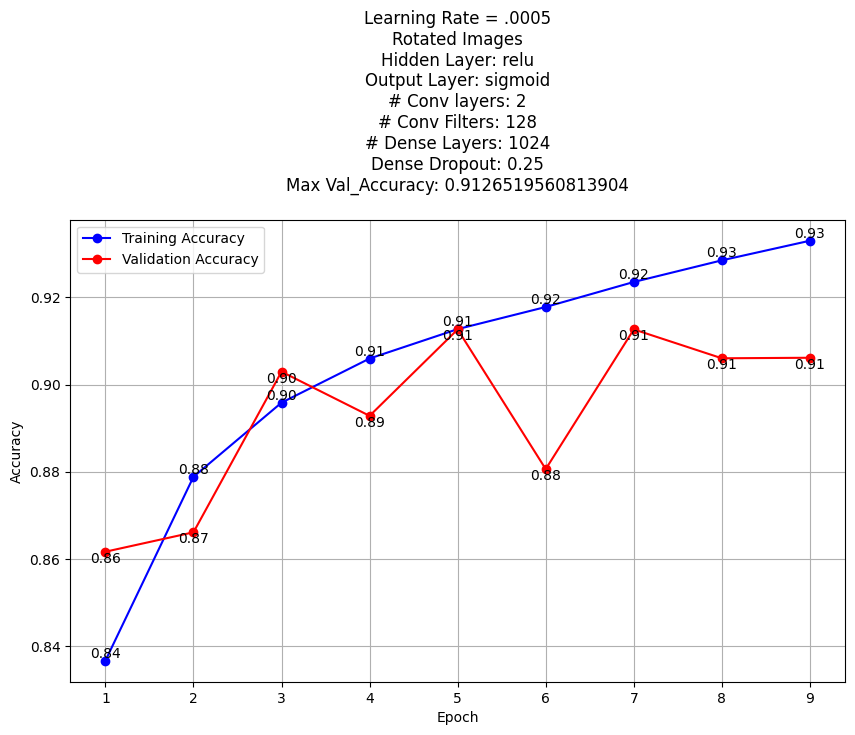

In [15]:
output_layer ="sigmoid"
hidden_layer = "relu"
h_layer_count = 2
dense_layers  = 1
dropout_value = .25
convolution_filter = 128


inputs = keras.Input(shape=(32,32,3))
convolution = inputs
convolution = convolution_block(convolution, convolution_filter, hidden_layer)
convolution = convolution_block(convolution, convolution_filter, hidden_layer)
convolution = pool_block(convolution)
convolution = convolution_block(convolution, convolution_filter, hidden_layer)
convolution = convolution_block(convolution, convolution_filter, hidden_layer)
convolution = pool_block(convolution) 

flatten= keras.layers.Flatten()(convolution)

activation = flatten

activation = activation_block(activation,1024)
activation = dropout_block(activation, dropout_value)

outputs = keras.layers.Dense(1, activation=output_layer)(activation)
full_model = keras.Model(inputs, outputs)

text = (
    f"Learning Rate = .0005\n"
    f"Rotated Images\n"
    f"Hidden Layer: {hidden_layer}\n"
    f"Output Layer: {output_layer}\n"
    f"# Conv layers: {h_layer_count}\n"
    f"# Conv Filters: {convolution_filter}\n"
    f"# Dense Layers: 1024\n"
    f'Dense Dropout: {dropout_value}\n'
)

start_time = timeit.default_timer()
callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy",patience=2)
_, history = run_model(full_model, .0005, X_rotated, y_rotated, epochs = 15, callbacks = callback)
print("Execution Time: " + str(timeit.default_timer() - start_time))
text = text + f'Max Val_Accuracy: {max(history.history["val_binary_accuracy"])}\n'
plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
#plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
del(full_model)
reset_keras()

# Batch normalization
Mistake #IDK.  I did not add batch normalization till near the end, while it should have been added at the beginnig.  This brought my overall model up to just below 93% accurate on the validation set.

Execution Time: 274.8194592387881


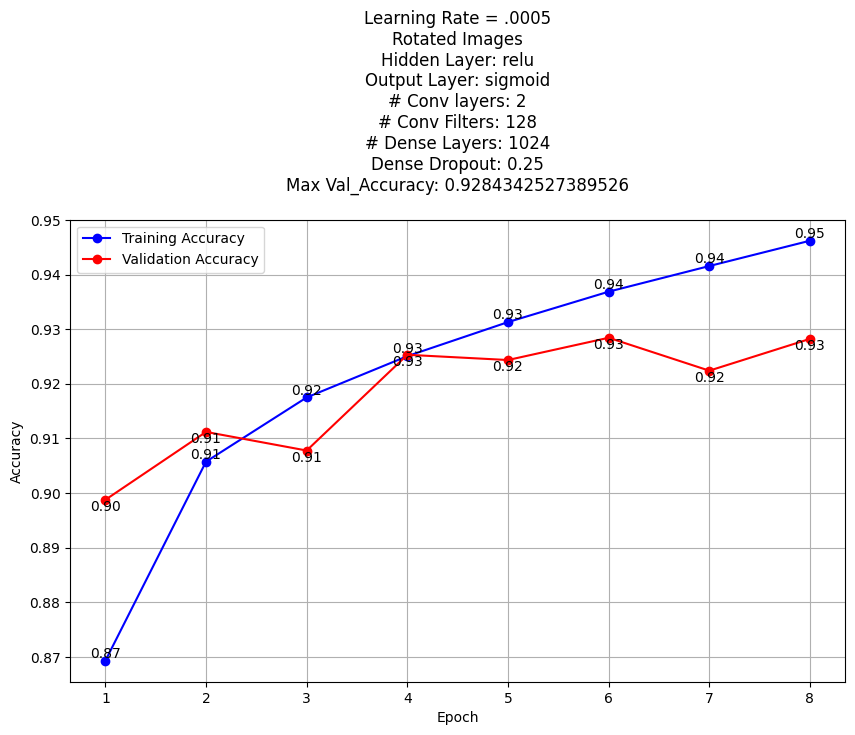

In [16]:
output_layer ="sigmoid"
hidden_layer = "relu"
h_layer_count = 2
dense_layers  = 1
dropout_value = .25
convolution_filter = 128


inputs = keras.Input(shape=(32,32,3))
# Batch Normalization
normalize = keras.layers.BatchNormalization(
    axis=1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True,
    beta_initializer="zeros",
    gamma_initializer="ones",
    moving_mean_initializer="zeros",
    moving_variance_initializer="ones",
    beta_regularizer=None,
    gamma_regularizer=None,
    beta_constraint=None,
    gamma_constraint=None,
    synchronized=False,
) (inputs)

convolution = normalize
convolution = convolution_block(convolution, convolution_filter, hidden_layer)
convolution = convolution_block(convolution, convolution_filter, hidden_layer)
convolution = pool_block(convolution)
convolution = convolution_block(convolution, convolution_filter, hidden_layer)
convolution = convolution_block(convolution, convolution_filter, hidden_layer)
convolution = pool_block(convolution) 

flatten= keras.layers.Flatten()(convolution)

activation = flatten

activation = activation_block(activation,1024)
activation = dropout_block(activation, dropout_value)

outputs = keras.layers.Dense(1, activation=output_layer)(activation)
full_model = keras.Model(inputs, outputs)

text = (
    f"Learning Rate = .0005\n"
    f"Rotated Images\n"
    f"Hidden Layer: {hidden_layer}\n"
    f"Output Layer: {output_layer}\n"
    f"# Conv layers: {h_layer_count}\n"
    f"# Conv Filters: {convolution_filter}\n"
    f"# Dense Layers: 1024\n"
    f'Dense Dropout: {dropout_value}\n'
)

start_time = timeit.default_timer()
callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy",patience=2)
_, history = run_model(full_model, .0005, X_rotated, y_rotated, epochs = 15, callbacks = callback)
print("Execution Time: " + str(timeit.default_timer() - start_time))
text = text + f'Max Val_Accuracy: {max(history.history["val_binary_accuracy"])}\n'
plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
#plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
del(full_model)
reset_keras()

## 1 Last double check

Execution Time: 205.74400190496817


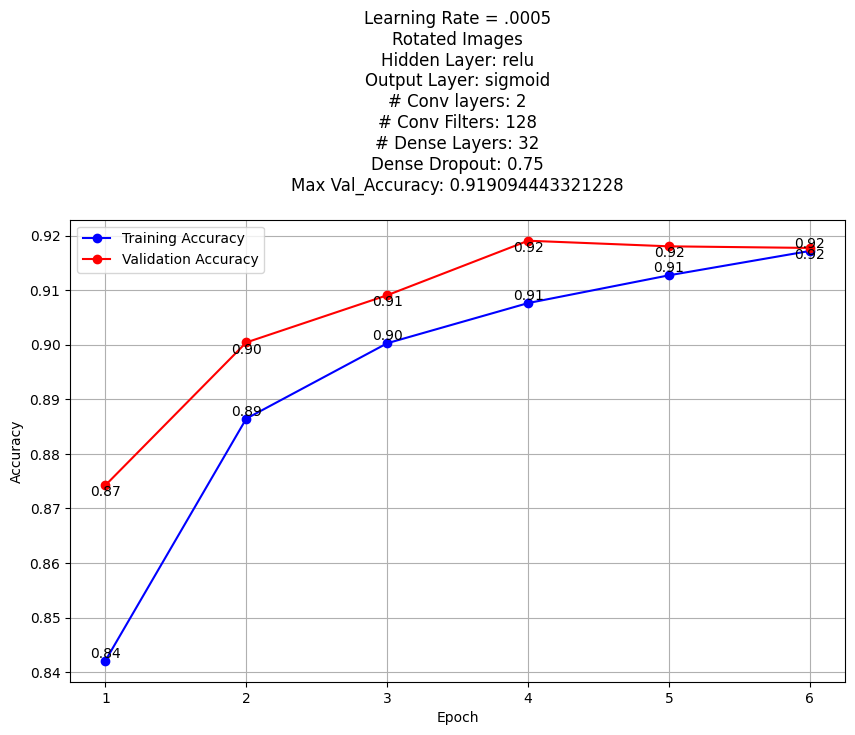

Execution Time: 266.49603103799745


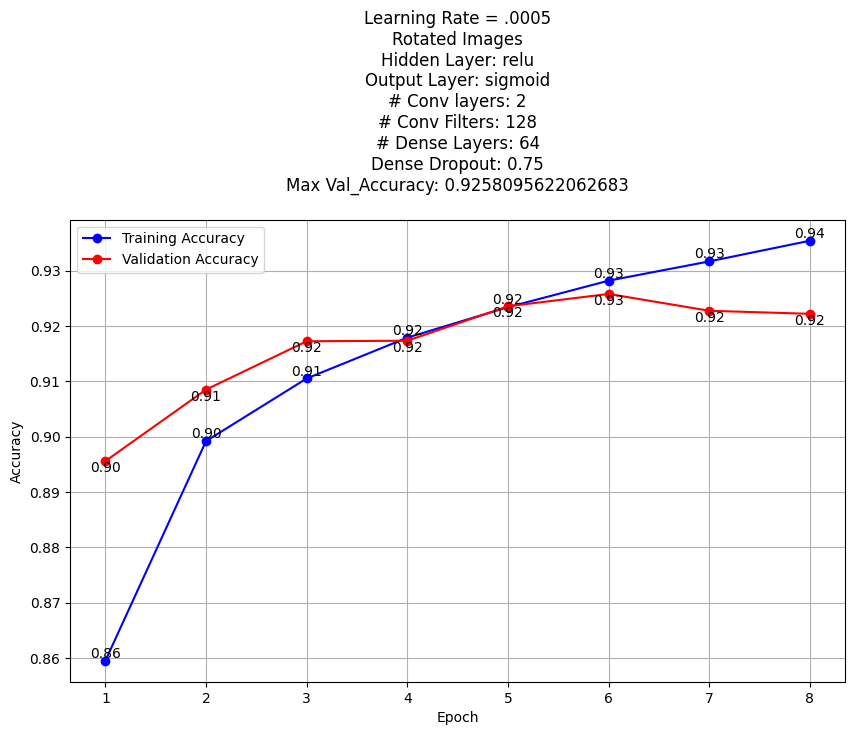

Execution Time: 206.5780474951025


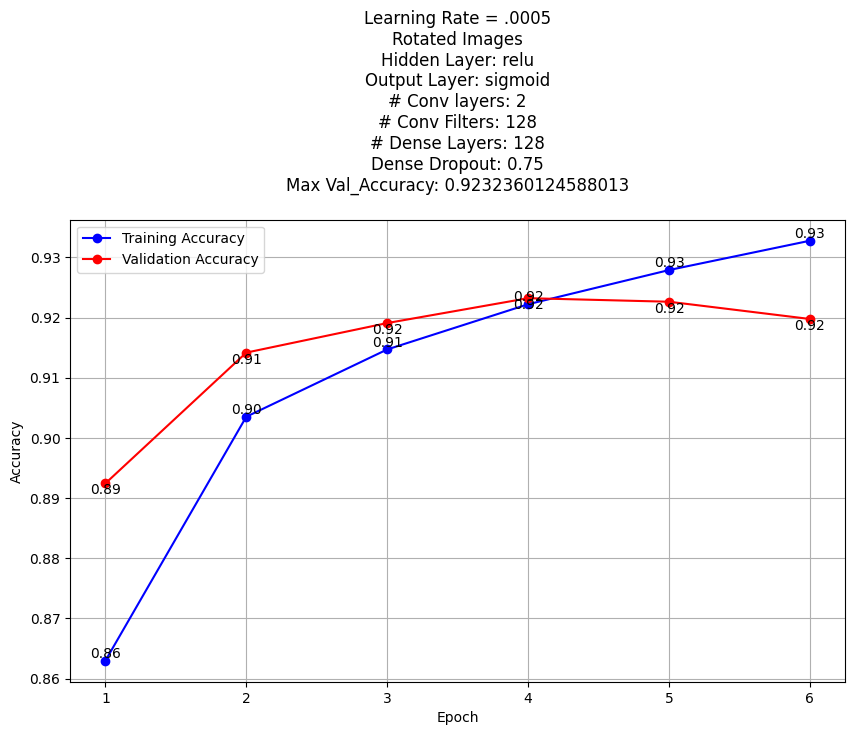

Execution Time: 361.29834735789336


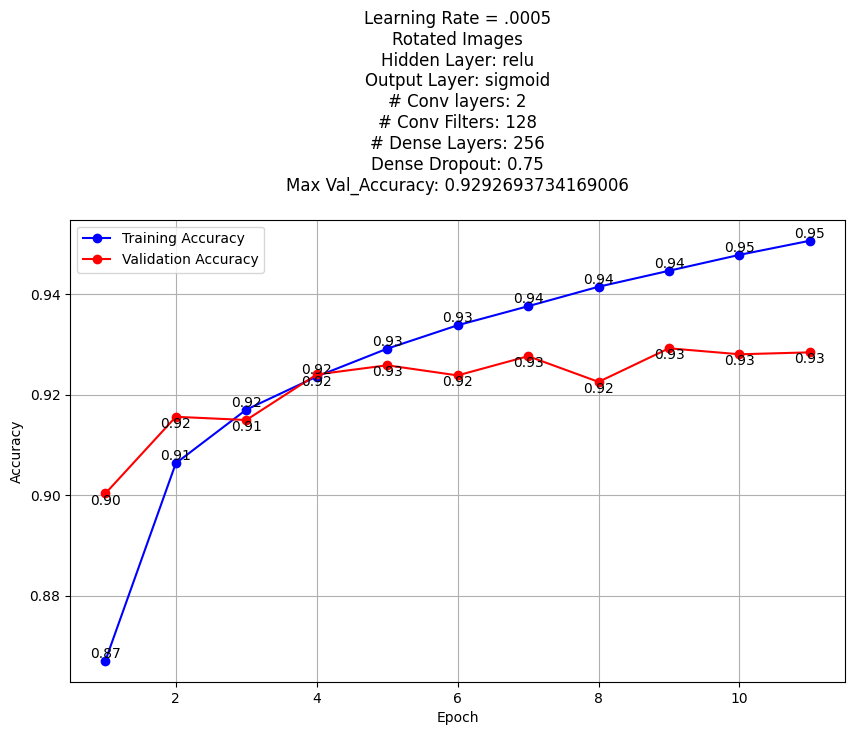

Execution Time: 300.53835036512464


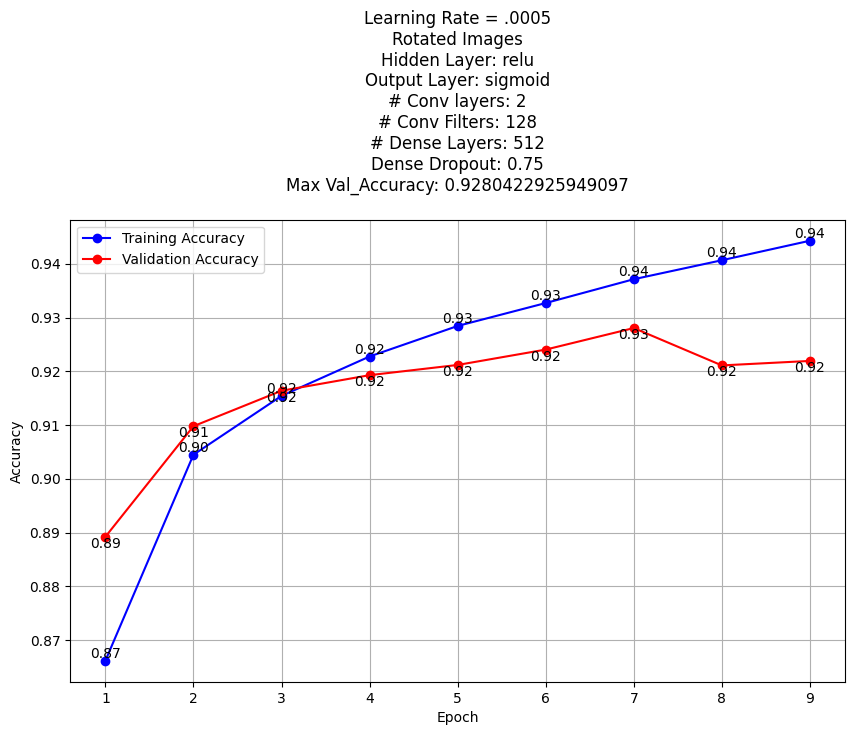

Execution Time: 336.1819606150966


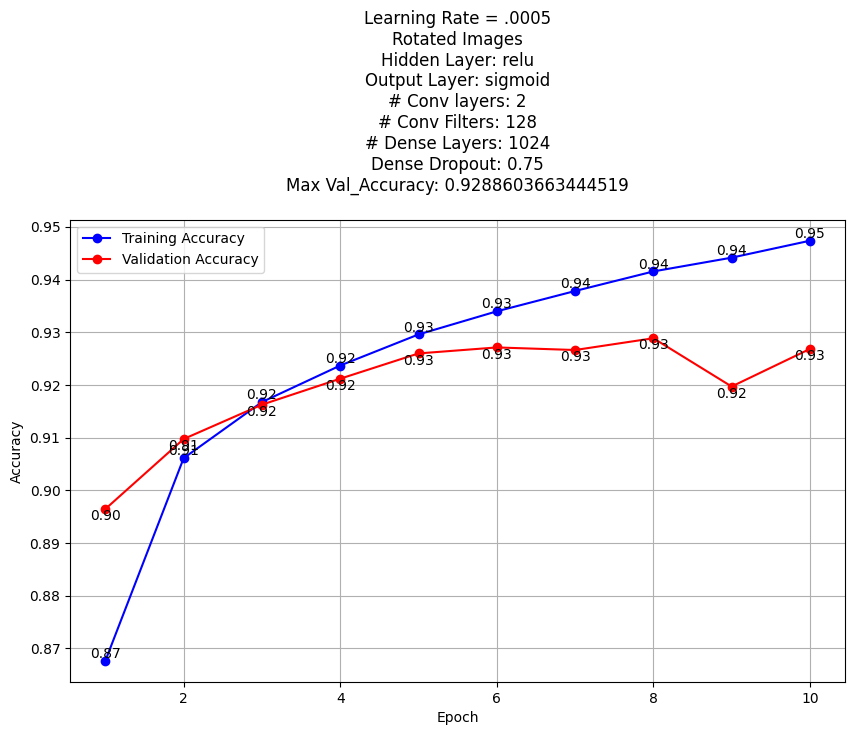

In [20]:
output_layer ="sigmoid"
hidden_layer = "relu"
h_layer_count = 2
dense_layers  = 1
dropout_value = .75
convolution_filter = 128
dense_sizes= [32,64,128,256,512,1024]

for dense_size in dense_sizes:
    inputs = keras.Input(shape=(32,32,3))
    # Batch Normalization
    normalize = keras.layers.BatchNormalization(
        axis=1,
        momentum=0.99,
        epsilon=0.001,
        center=True,
        scale=True,
        beta_initializer="zeros",
        gamma_initializer="ones",
        moving_mean_initializer="zeros",
        moving_variance_initializer="ones",
        beta_regularizer=None,
        gamma_regularizer=None,
        beta_constraint=None,
        gamma_constraint=None,
        synchronized=False,
    ) (inputs)
    
    convolution = normalize
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = pool_block(convolution)
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = pool_block(convolution) 
    
    flatten= keras.layers.Flatten()(convolution)
    
    activation = flatten
    
    activation = activation_block(activation,dense_size)
    activation = dropout_block(activation, dropout_value)
    
    
    outputs = keras.layers.Dense(1, activation=output_layer)(activation)
    full_model = keras.Model(inputs, outputs)
    
    text = (
        f"Learning Rate = .0005\n"
        f"Rotated Images\n"
        f"Hidden Layer: {hidden_layer}\n"
        f"Output Layer: {output_layer}\n"
        f"# Conv layers: {h_layer_count}\n"
        f"# Conv Filters: {convolution_filter}\n"
        f"# Dense Layers: {dense_size}\n"
        f'Dense Dropout: {dropout_value}\n'
    )
    
    start_time = timeit.default_timer()
    callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy",patience=2)
    _, history = run_model(full_model, .0005, X_rotated, y_rotated, epochs = 15, callbacks = callback)
    print("Execution Time: " + str(timeit.default_timer() - start_time))
    text = text + f'Max Val_Accuracy: {max(history.history["val_binary_accuracy"])}\n'
    plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
    #plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
    del(full_model)
    reset_keras()

## Adding a second Dense Layer

Execution Time: 343.60464925598353


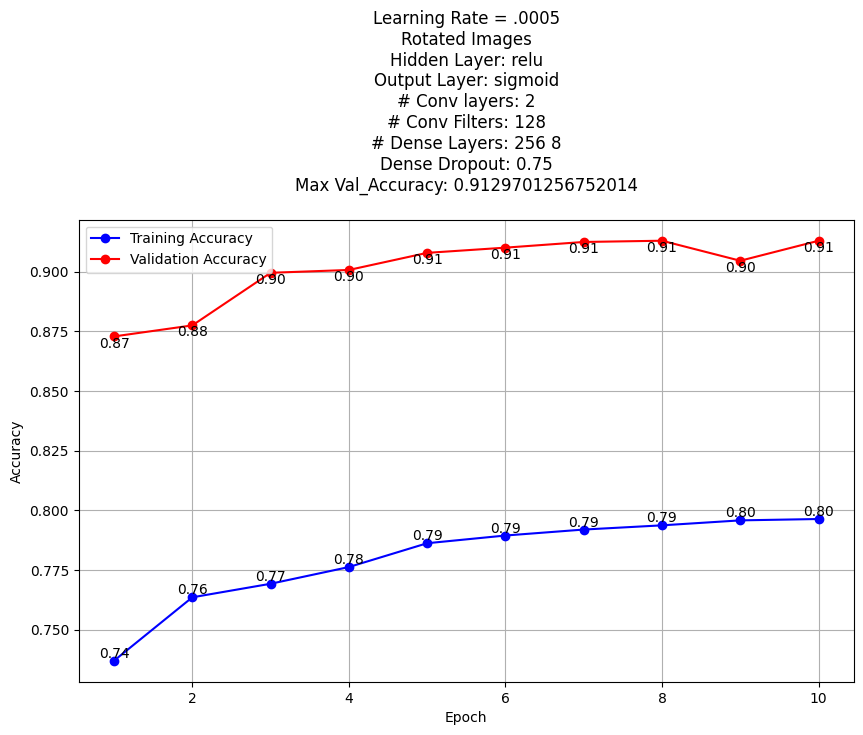

I0000 00:00:1714218337.912026    4710 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_99', 8 bytes spill stores, 8 bytes spill loads



Execution Time: 374.6914160759188


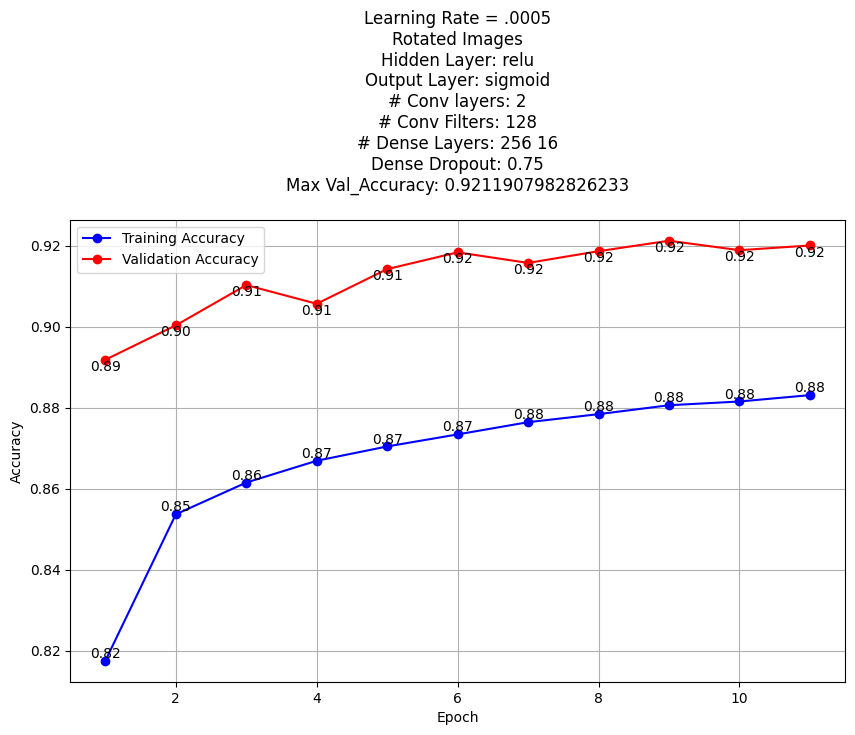

I0000 00:00:1714218713.607307    6133 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_99', 8 bytes spill stores, 8 bytes spill loads



Execution Time: 186.7982055239845


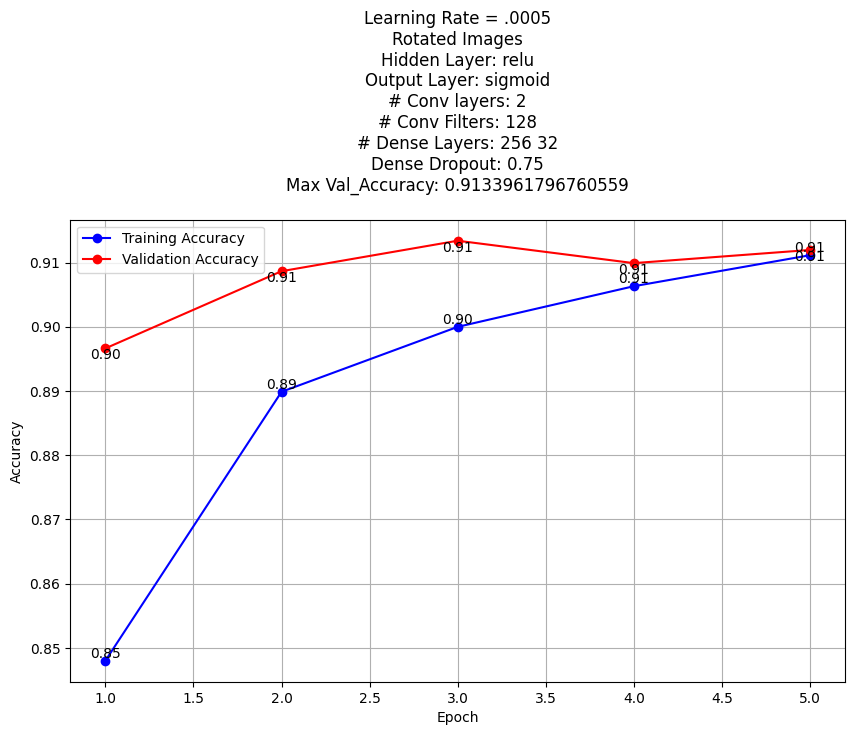

I0000 00:00:1714218898.109130    6846 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_99', 72 bytes spill stores, 72 bytes spill loads



Execution Time: 347.8709141118452


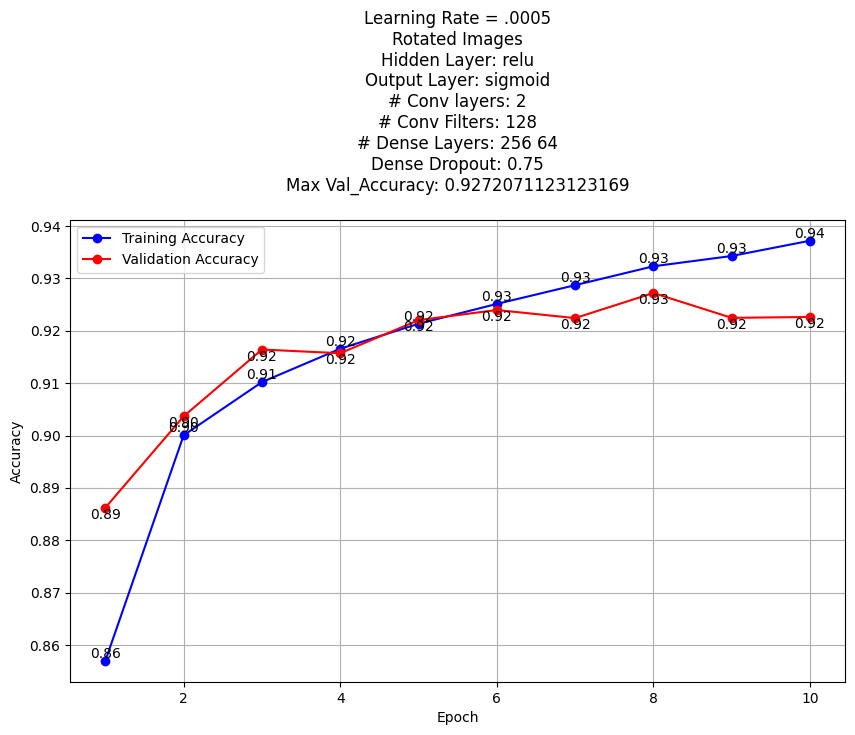

I0000 00:00:1714219245.932818    8156 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_99', 40 bytes spill stores, 40 bytes spill loads



Execution Time: 218.32289177691564


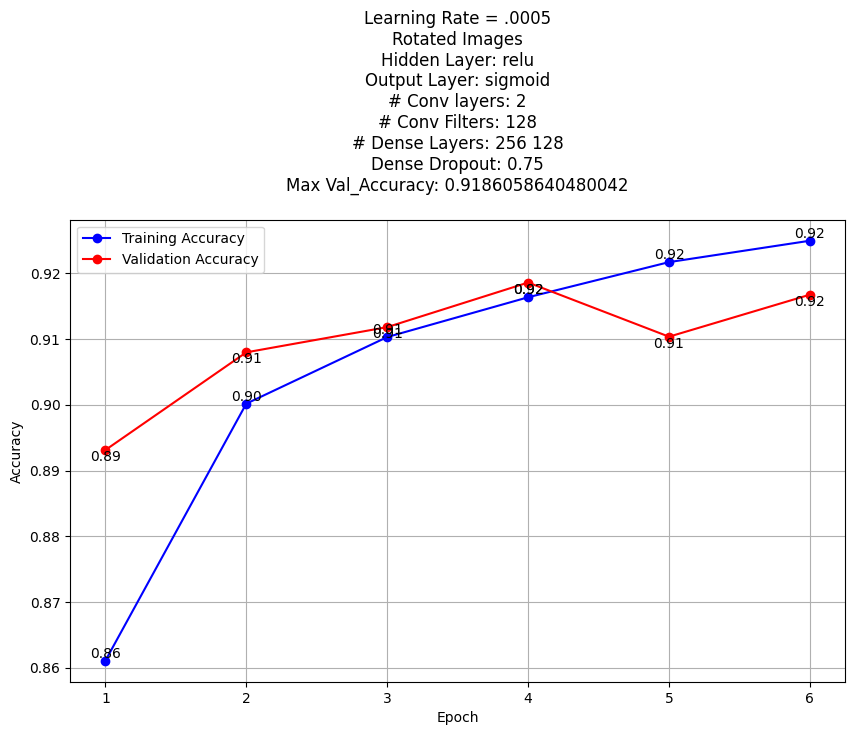

I0000 00:00:1714219464.841932    9022 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_99', 24 bytes spill stores, 24 bytes spill loads



Execution Time: 314.8138830848038


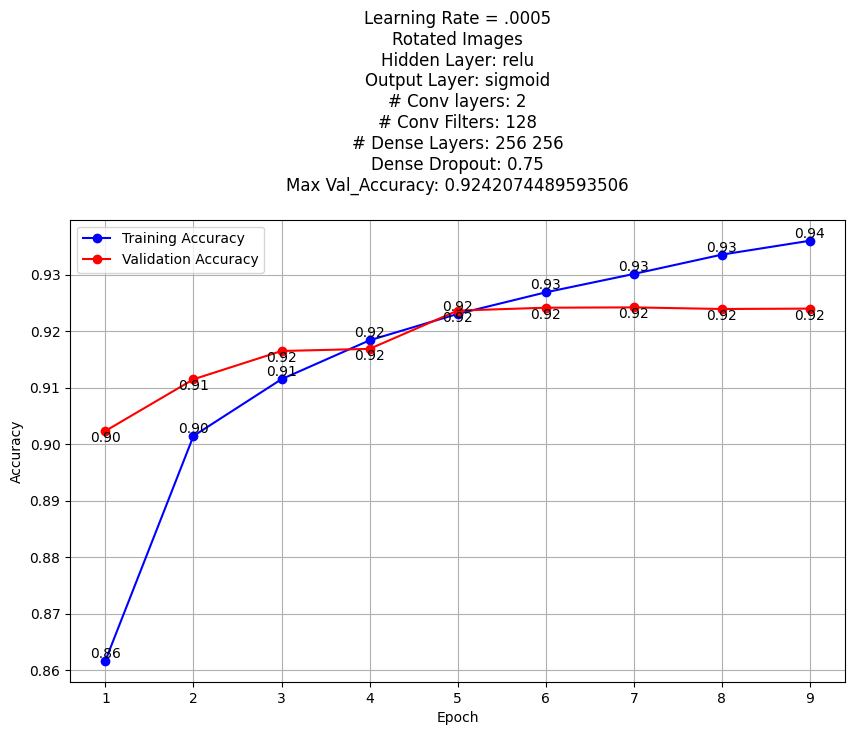

I0000 00:00:1714219780.241600   10209 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_99', 40 bytes spill stores, 40 bytes spill loads



Execution Time: 407.0235245649237


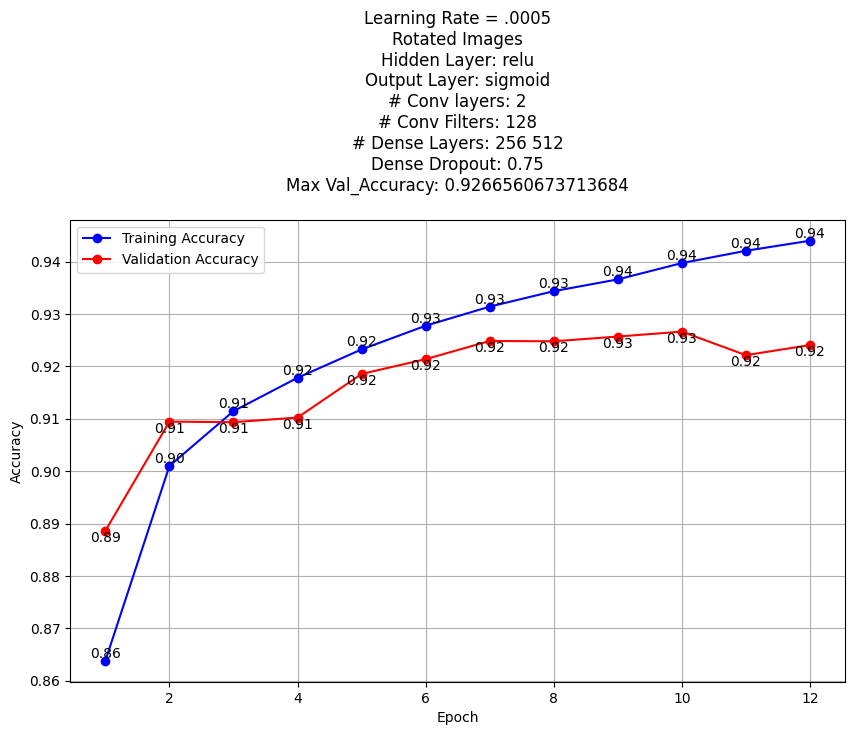

In [13]:
output_layer ="sigmoid"
hidden_layer = "relu"
h_layer_count = 2
dense_layers  = 1
dropout_value = .75
convolution_filter = 128
dense_sizes= [8,16,32,64,128,256,512]

for dense_size in dense_sizes:
    inputs = keras.Input(shape=(32,32,3))
    # Batch Normalization
    normalize = keras.layers.BatchNormalization(
        axis=1,
        momentum=0.99,
        epsilon=0.001,
        center=True,
        scale=True,
        beta_initializer="zeros",
        gamma_initializer="ones",
        moving_mean_initializer="zeros",
        moving_variance_initializer="ones",
        beta_regularizer=None,
        gamma_regularizer=None,
        beta_constraint=None,
        gamma_constraint=None,
        synchronized=False,
    ) (inputs)
    
    convolution = normalize
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = pool_block(convolution)
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = pool_block(convolution) 
    
    flatten= keras.layers.Flatten()(convolution)
    
    activation = flatten
    
    activation = activation_block(activation,256)
    activation = dropout_block(activation, dropout_value)
        
    activation = activation_block(activation,dense_size)
    activation = dropout_block(activation, dropout_value)
    
    outputs = keras.layers.Dense(1, activation=output_layer)(activation)
    full_model = keras.Model(inputs, outputs)
    
    text = (
        f"Learning Rate = .0005\n"
        f"Rotated Images\n"
        f"Hidden Layer: {hidden_layer}\n"
        f"Output Layer: {output_layer}\n"
        f"# Conv layers: {h_layer_count}\n"
        f"# Conv Filters: {convolution_filter}\n"
        f"# Dense Layers: 256 {dense_size}\n"
        f'Dense Dropout: {dropout_value}\n'
    )
    
    start_time = timeit.default_timer()
    callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy",patience=2)
    _, history = run_model(full_model, .0005, X_rotated, y_rotated, epochs = 15, callbacks = callback)
    print("Execution Time: " + str(timeit.default_timer() - start_time))
    text = text + f'Max Val_Accuracy: {max(history.history["val_binary_accuracy"])}\n'
    plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
    #plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
    del(full_model)
    reset_keras()

# Dropout Optomization
I spoke to this above.


Execution Time: 212.5114715900272


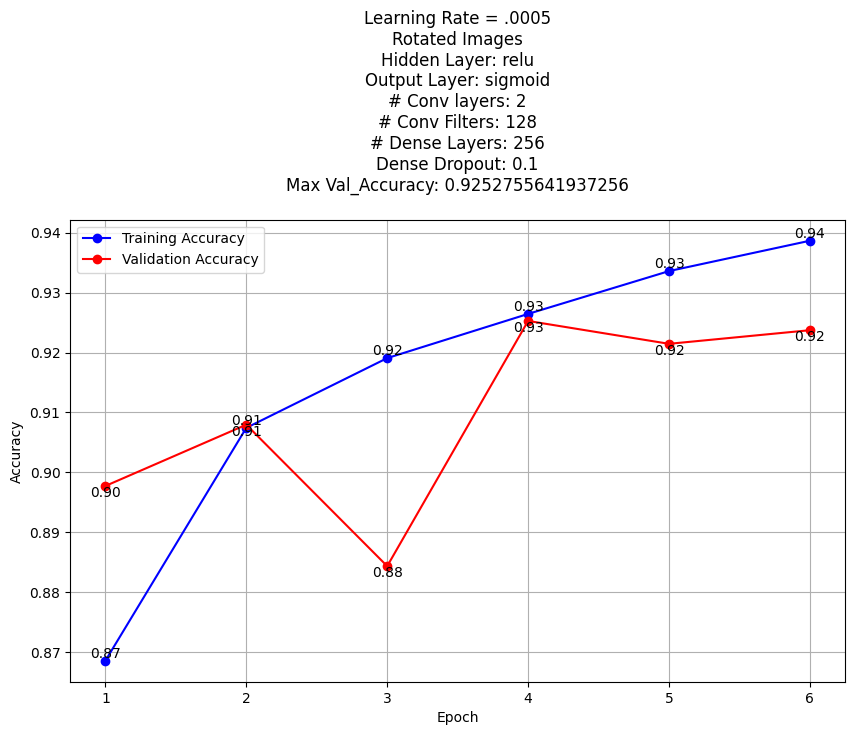

Execution Time: 337.5395023629535


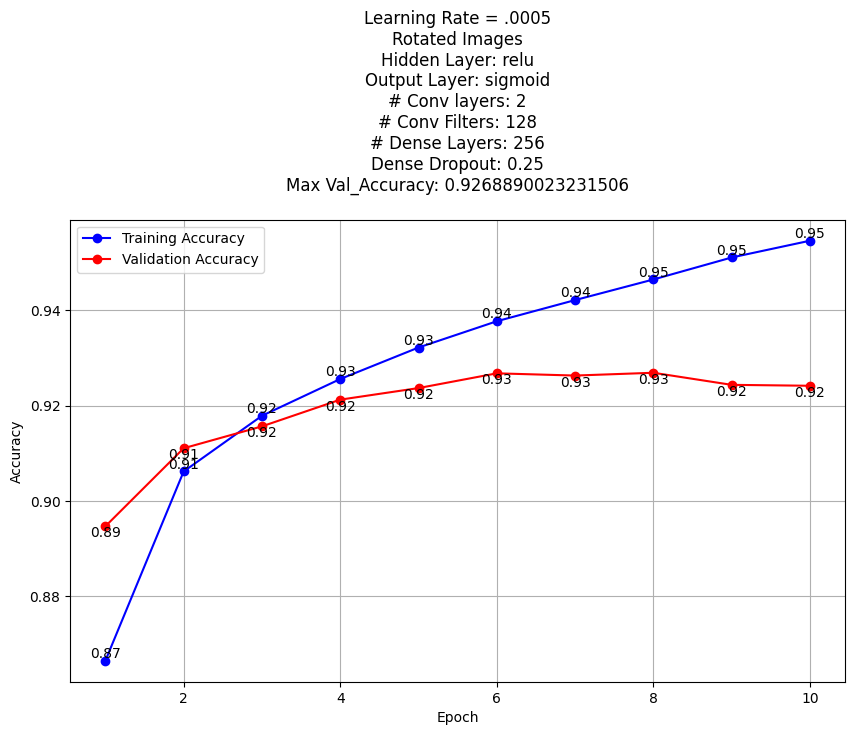

Execution Time: 303.3988964918535


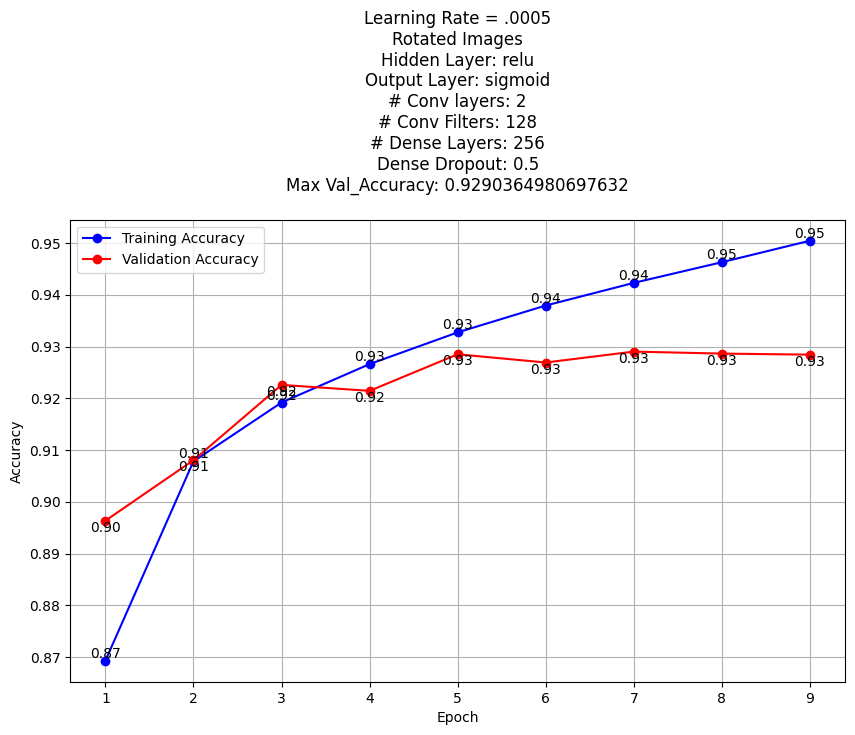

Execution Time: 399.52872050600126


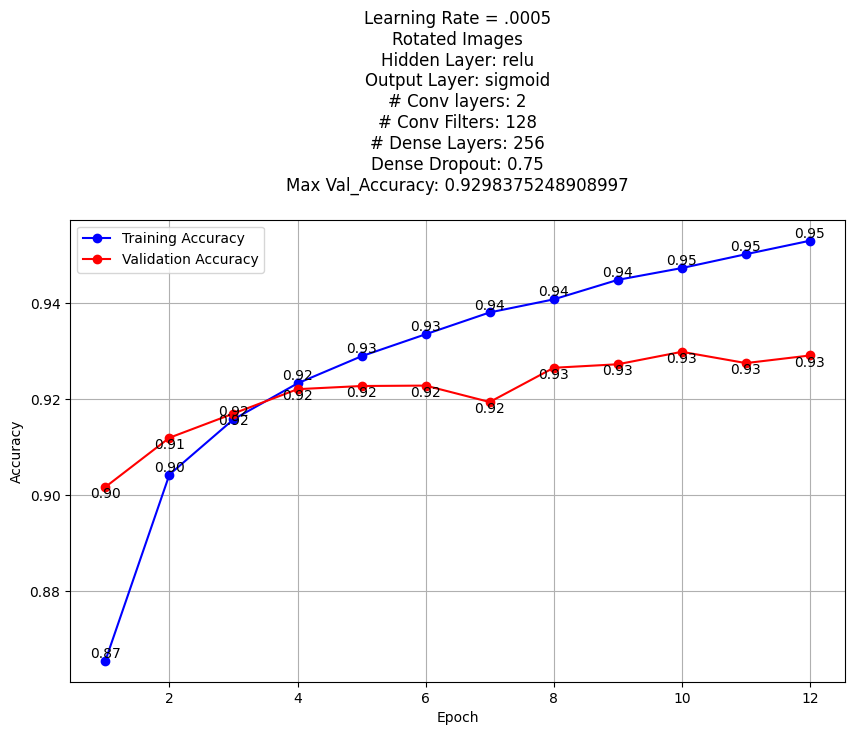

Execution Time: 335.7634447000455


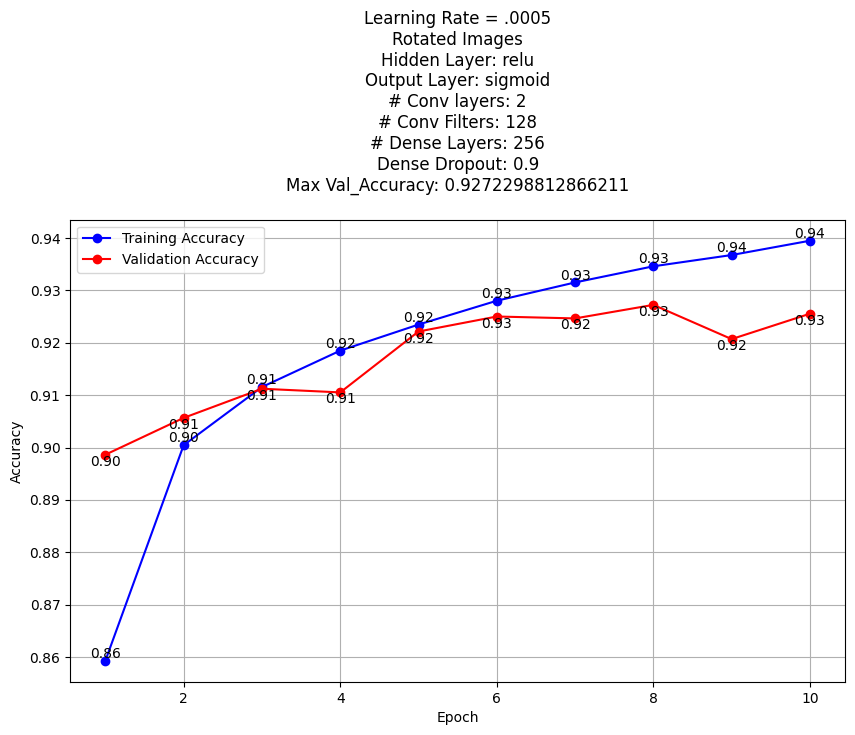

In [14]:
output_layer ="sigmoid"
hidden_layer = "relu"
h_layer_count = 2
dense_layers  = 1
dropout_value = .75
convolution_filter = 128
dropout_values = [.1, .25, .5, .75, .9]

for dropout_value in dropout_values:
    inputs = keras.Input(shape=(32,32,3))
    # Batch Normalization
    normalize = keras.layers.BatchNormalization(
        axis=1,
        momentum=0.99,
        epsilon=0.001,
        center=True,
        scale=True,
        beta_initializer="zeros",
        gamma_initializer="ones",
        moving_mean_initializer="zeros",
        moving_variance_initializer="ones",
        beta_regularizer=None,
        gamma_regularizer=None,
        beta_constraint=None,
        gamma_constraint=None,
        synchronized=False,
    ) (inputs)
    
    convolution = normalize
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = pool_block(convolution)
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = pool_block(convolution) 
    
    flatten= keras.layers.Flatten()(convolution)
    
    activation = flatten
    
    activation = activation_block(activation,256)
    activation = dropout_block(activation, dropout_value)
    
    outputs = keras.layers.Dense(1, activation=output_layer)(activation)
    full_model = keras.Model(inputs, outputs)
    
    text = (
        f"Learning Rate = .0005\n"
        f"Rotated Images\n"
        f"Hidden Layer: {hidden_layer}\n"
        f"Output Layer: {output_layer}\n"
        f"# Conv layers: {h_layer_count}\n"
        f"# Conv Filters: {convolution_filter}\n"
        f"# Dense Layers: 256\n"
        f'Dense Dropout: {dropout_value}\n'
    )
    
    start_time = timeit.default_timer()
    callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy",patience=2)
    _, history = run_model(full_model, .0005, X_rotated, y_rotated, epochs = 15, callbacks = callback)
    print("Execution Time: " + str(timeit.default_timer() - start_time))
    text = text + f'Max Val_Accuracy: {max(history.history["val_binary_accuracy"])}\n'
    plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
    #plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
    del(full_model)
    reset_keras()

In [ ]:
## Trying the dropout values witha slightly lower learning rate

Execution Time: 556.5711692308541


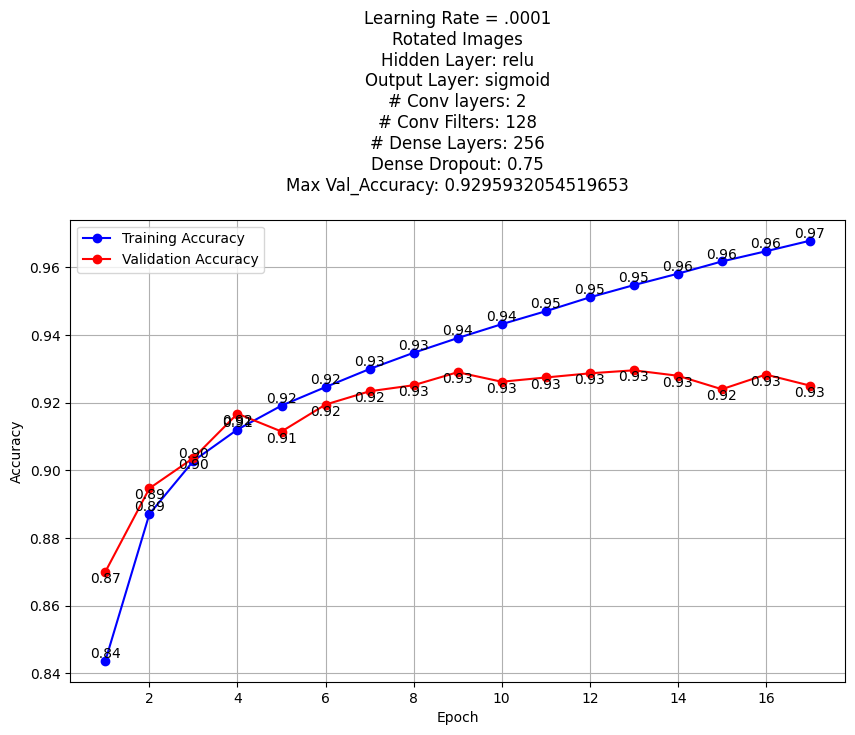

Execution Time: 586.8020002089906


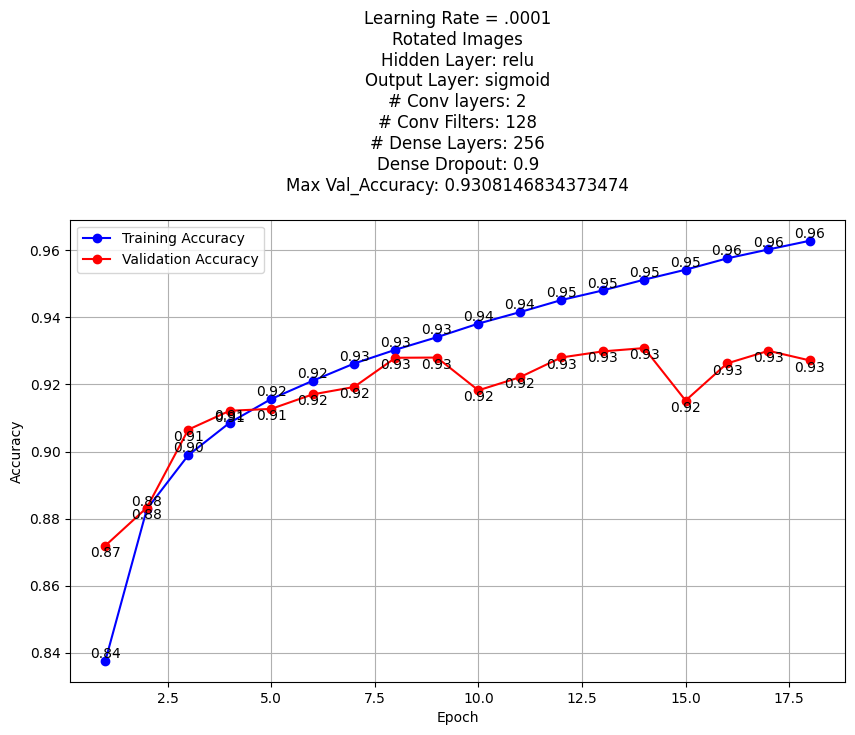

In [15]:
output_layer ="sigmoid"
hidden_layer = "relu"
h_layer_count = 2
dense_layers  = 1
dropout_value = .75
convolution_filter = 128
dropout_values = [.75, .9]

for dropout_value in dropout_values:
    inputs = keras.Input(shape=(32,32,3))
    # Batch Normalization
    normalize = keras.layers.BatchNormalization(
        axis=1,
        momentum=0.99,
        epsilon=0.001,
        center=True,
        scale=True,
        beta_initializer="zeros",
        gamma_initializer="ones",
        moving_mean_initializer="zeros",
        moving_variance_initializer="ones",
        beta_regularizer=None,
        gamma_regularizer=None,
        beta_constraint=None,
        gamma_constraint=None,
        synchronized=False,
    ) (inputs)
    
    convolution = normalize
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = pool_block(convolution)
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = pool_block(convolution) 
    
    flatten= keras.layers.Flatten()(convolution)
    
    activation = flatten
    
    activation = activation_block(activation,256)
    activation = dropout_block(activation, dropout_value)
    
    outputs = keras.layers.Dense(1, activation=output_layer)(activation)
    full_model = keras.Model(inputs, outputs)
    
    text = (
        f"Learning Rate = .0001\n"
        f"Rotated Images\n"
        f"Hidden Layer: {hidden_layer}\n"
        f"Output Layer: {output_layer}\n"
        f"# Conv layers: {h_layer_count}\n"
        f"# Conv Filters: {convolution_filter}\n"
        f"# Dense Layers: 256\n"
        f'Dense Dropout: {dropout_value}\n'
    )
    
    start_time = timeit.default_timer()
    callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy",patience=4)
    _, history = run_model(full_model, .0001, X_rotated, y_rotated, epochs = 20, callbacks = callback)
    print("Execution Time: " + str(timeit.default_timer() - start_time))
    text = text + f'Max Val_Accuracy: {max(history.history["val_binary_accuracy"])}\n'
    plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
    #plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
    del(full_model)
    reset_keras()

## Final Run with saving the best model
This is my final run with my preferred settings.  I saved this model to create my results for upload.

2024-04-27 16:32:58.962718: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8651735040 exceeds 10% of free system memory.


Execution Time: 664.0522966369754


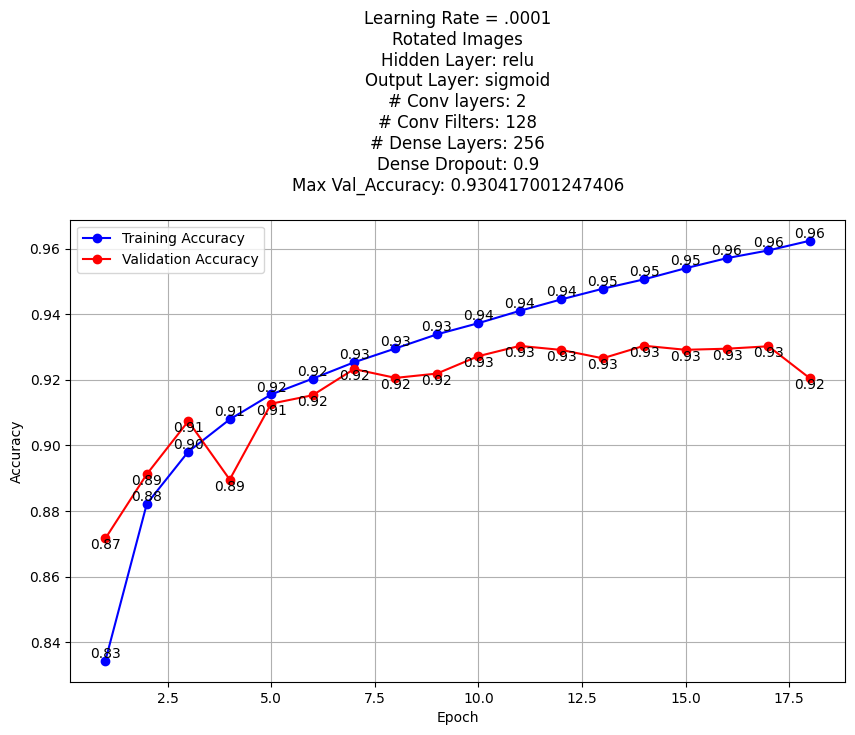

In [22]:
output_layer ="sigmoid"
hidden_layer = "relu"
h_layer_count = 2
dense_layers  = 1
dropout_value = .75
convolution_filter = 128
dropout_value = .9


inputs = keras.Input(shape=(32,32,3))
# Batch Normalization
normalize = keras.layers.BatchNormalization(
    axis=1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True,
    beta_initializer="zeros",
    gamma_initializer="ones",
    moving_mean_initializer="zeros",
    moving_variance_initializer="ones",
    beta_regularizer=None,
    gamma_regularizer=None,
    beta_constraint=None,
    gamma_constraint=None,
    synchronized=False,
) (inputs)

convolution = normalize
convolution = convolution_block(convolution, convolution_filter, hidden_layer)
convolution = convolution_block(convolution, convolution_filter, hidden_layer)
convolution = pool_block(convolution)
convolution = convolution_block(convolution, convolution_filter, hidden_layer)
convolution = convolution_block(convolution, convolution_filter, hidden_layer)
convolution = pool_block(convolution) 

flatten= keras.layers.Flatten()(convolution)

activation = flatten

activation = activation_block(activation,256)
activation = dropout_block(activation, dropout_value)

outputs = keras.layers.Dense(1, activation=output_layer)(activation)
full_model = keras.Model(inputs, outputs)

text = (
    f"Learning Rate = .0001\n"
    f"Rotated Images\n"
    f"Hidden Layer: {hidden_layer}\n"
    f"Output Layer: {output_layer}\n"
    f"# Conv layers: {h_layer_count}\n"
    f"# Conv Filters: {convolution_filter}\n"
    f"# Dense Layers: 256\n"
    f'Dense Dropout: {dropout_value}\n'
)

start_time = timeit.default_timer()
callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy",patience=4)

# Adding save of best model.  Code REF https://keras.io/api/callbacks/model_checkpoint/
checkpoint_filepath = 'kaggle/working/checkpoint.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True)

    
_, history = run_model(full_model, .0001, X_rotated, y_rotated, epochs = 20, callbacks = [callback, model_checkpoint_callback])
print("Execution Time: " + str(timeit.default_timer() - start_time))
text = text + f'Max Val_Accuracy: {max(history.history["val_binary_accuracy"])}\n'
plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)


In [14]:
def load_and_process_image(filename):
    path=input_directory + "test/" + filename + ".tif"
    im = keras.utils.load_img(path, color_mode='rgb', target_size=(32,32))
    return keras.utils.img_to_array(im)/255


In [16]:
directory = input_directory + "sample_submission.csv"
test_images = pd.read_csv(directory)
test_images['image_data'] = test_images['id'].apply(load_and_process_image)
X_val = np.stack(test_images['image_data'].values)

In [20]:
final_model = keras.saving.load_model(working_directory + "checkpoint.keras", custom_objects=None, compile=True, safe_mode=True)

In [21]:
y_val = final_model.predict(X_val)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [29]:
test_images['label'] = y_val
print(test_images.columns)
test_images = test_images.drop(labels = "image_data", axis = 1)
print(test_images.head)

Index(['id', 'label', 'image_data'], dtype='object')
<bound method NDFrame.head of                                              id     label
0      0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5  0.002000
1      95596b92e5066c5c52466c90b69ff089b39f2737  0.008944
2      248e6738860e2ebcf6258cdc1f32f299e0c76914  0.000168
3      2c35657e312966e9294eac6841726ff3a748febf  0.001543
4      145782eb7caa1c516acbe2eda34d9a3f31c41fd6  0.336629
...                                         ...       ...
57453  061847314ded6f81e1cd670748bfa2003442c9c7  0.015715
57454  6f3977130212641fd5808210015a609c658dcbff  0.004660
57455  46935f247278539eca74b54d07d666efb528a753  0.000020
57456  a09bcae08a82120183352e0e869181b2911d3dc1  0.000070
57457  d29233dc0b90c2e1a8fcedbc3e1234c3d4dbd55b  0.000535

[57458 rows x 2 columns]>


In [30]:
test_images.to_csv(path_or_buf= directory)

# Results
My overall results were ~93% accurate.  I expect my score in the actual set to be similar.  I learned alot about tuning hyperparametrs and how they work together to make a model.  Rotating the images, and finding the correct dense layer count were very valuable to creating a good model, but I only got %4 better than the base model I created.

# Lessons learned
- Use a powerfull enough computer to do training with plenty of memory
- Next time, I will use pytorch.  Pytorch does not seem to suffer from the memory leak and comes with a system called raytune, which will automagically find the optimal hyperparameters.
- Be faster.  I learned alot about the computing and my mistakes.  This turned into a 36 hour project, but was a fun learning expirence.